------

# Лемматизация, кластеризация и составление модели прогнозирования выполненны во второй половине работы

------

In [1236]:
from scipy import stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

------

# Шаг 1. Загрузить данные и подготовить их к анализу

------

In [1237]:
data = pd.read_csv('D://data/ecommerce_dataset.csv')

In [1238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [1239]:
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


1. Есть следующие проблемы в данных 
   - Дата представлена в секундах и необходимо ее перевести в формат datetime64
   

Переведем дату в формат datetime64

In [1240]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

In [1241]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null datetime64[ns]
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 315.9+ KB


In [1242]:
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Проверим на пропуски и дубликаты

In [1243]:
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [1244]:
data.duplicated().sum()

0

Один и тот же заказ может оформляться несколько дней, поэтому просмотрим дубликаты без учета дат

In [1245]:
data_index = data[['customer_id', 'order_id', 'product', 'quantity', 'price']]

In [1246]:
data_index.duplicated().sum()

1864

In [1247]:
data_index = data_index.drop_duplicates()

In [1248]:
data_index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4873 entries, 0 to 6735
Data columns (total 5 columns):
customer_id    4873 non-null object
order_id       4873 non-null int64
product        4873 non-null object
quantity       4873 non-null int64
price          4873 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 228.4+ KB


In [1249]:
data_index.groupby('order_id').nunique().sum()

customer_id    2817
order_id       2784
product        4817
quantity       2995
price          3559
dtype: int64

Было выявлено 1864 дубликатов удадим их

In [1250]:
data['del'] = data['order_id'].where(data.index.isin(data_index.index), 'delete')

In [1251]:
data_1 = data[data['del'] != 'delete']

Проверим на наличие 0 значений в столбцах "price" и "quantity"

In [1252]:
data_1[data_1['quantity'] == 0]

,date,customer_id,order_id,product,quantity,price,del


In [1253]:
data_1[data_1['price'] == 0]

,date,customer_id,order_id,product,quantity,price,del


В таблицу добавим столбец сумма как произведение столбца "price" и "quantity"

In [1254]:
data_1['summa'] = data_1['price'] * data['quantity']

D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1255]:
data_1['date'].describe()

count                    4873
unique                   2230
top       2019-04-27 16:00:00
freq                       51
first     2018-10-01 00:00:00
last      2019-10-31 14:00:00
Name: date, dtype: object

In [1256]:
data_1.describe()

,order_id,quantity,price,summa
count,4873.000000,4873.000000,4873.000000,4873.000000
mean,48231.287503,2.837472,514.749846,850.021342
std,27341.349829,17.606813,944.455480,9807.308006
min,12624.000000,1.000000,9.000000,9.000000
25%,14776.000000,1.000000,90.000000,120.000000
50%,68860.000000,1.000000,150.000000,194.000000
75%,70833.000000,1.000000,488.000000,734.000000
max,73164.000000,1000.000000,14917.000000,675000.000000


In [1257]:
name_columns =['quantity', 'price', 'summa']

In [1258]:
data_box = data_1[['quantity', 'price', 'summa']]

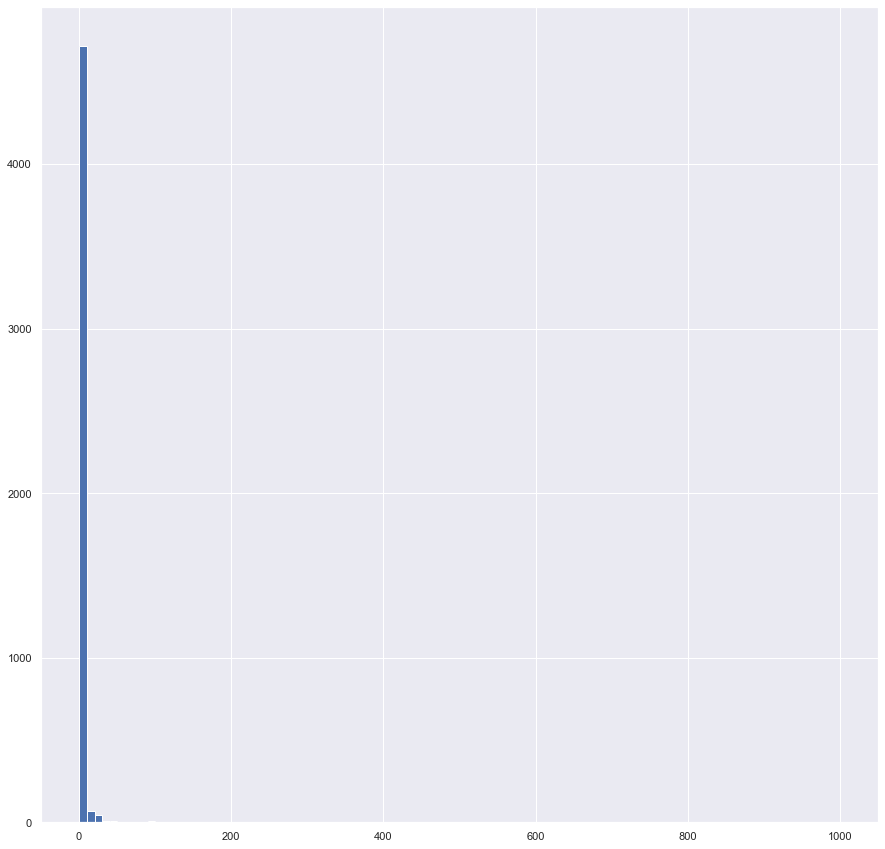

In [1259]:
data_1['quantity'].hist(bins = 100)

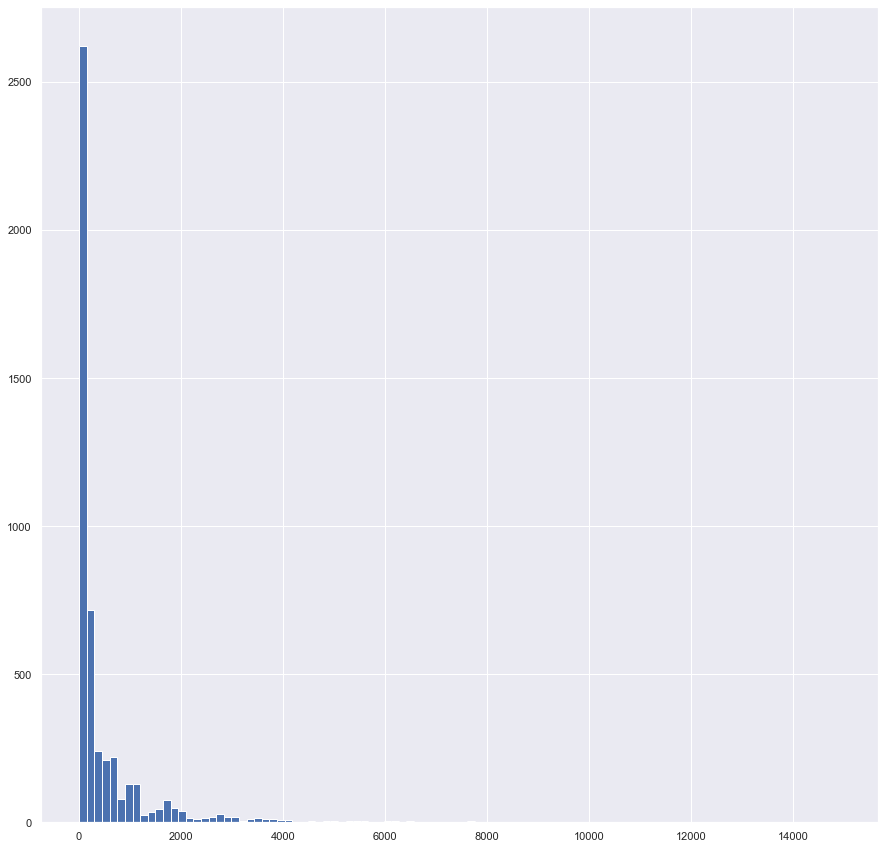

In [1260]:
data_1['price'].hist(bins = 100)

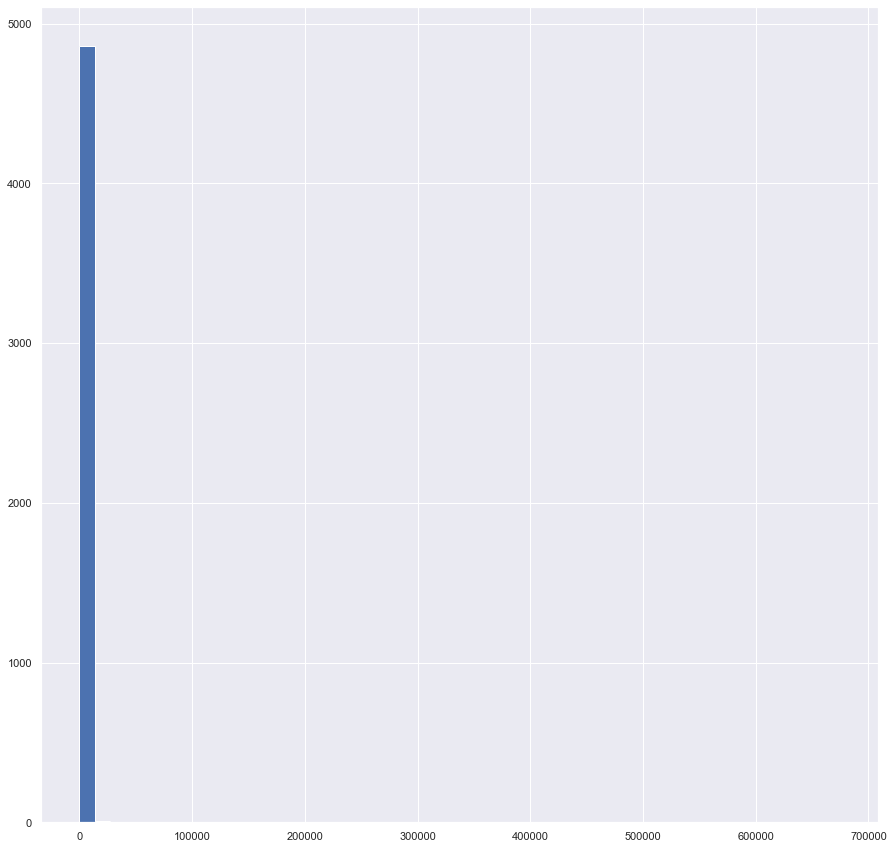

In [1261]:
data_1['summa'].hist(bins = 50)

Вывод:
----
   1. Общее количество покупаемых товаров в своем большенстве соотвествует 1 шт
   2. 75% покупаемых товаров не превышает 488 у.е. 
   3. 75% общая сумма затрат не превышает 734 у.е.
   4. Существуют выбросы от которых необходимо избавиться. Для очистки данных будем использовать столбик "summa" на основе  межквартильного расстояния  

Избавляемся от выбросов в summa

In [1262]:
interquartile_distance = np.percentile(data_1['summa'], 75)-np.percentile(data_1['summa'], 25)

In [1263]:
data_corr = data_1[data_1['summa'] <= (np.percentile(data_1['summa'], 75) + 1.5*interquartile_distance)]

In [1264]:
data_corr.describe()

,order_id,quantity,price,summa
count,4374.000000,4374.000000,4374.000000,4374.000000
mean,45758.475309,1.834019,295.532236,360.852080
std,27724.790582,3.234896,360.973823,387.213362
min,12624.000000,1.000000,9.000000,9.000000
25%,14755.000000,1.000000,90.000000,119.000000
50%,68699.000000,1.000000,142.000000,180.000000
75%,70622.250000,1.000000,329.000000,488.000000
max,73164.000000,70.000000,1649.000000,1649.000000


In [1265]:
data_corr_check = data_corr.groupby('order_id').agg({'quantity': 'count'}).reset_index()
data_check = data.groupby('order_id').agg({'quantity': 'count'}).reset_index()


In [1266]:
100 - 100*data_corr.shape[0] / data.shape[0]

35.0749591806442

Резюме о проделанной работе
-----
   1. Данные из столбца date переведены в формат datetime64
   2. Данные проверены на дубликаты и пропущенные данные.
   3. Данные проверены на выбросы. Обнаруженные выбросы на основе метода межквартального растояния убраны на основе столбца "summa". На данной операции сократили 10.24% покупок товаров

------

# Шаг 2. Анализ данных

------

- Исследовать какой объем покупок осуществляли покупатели в разрезе суток, часов и месяцев;
- Анализ среднего чека по пользователям;
- Когортный анализ на удержании клиентов
- Как изменяются траты при повторных покупках

In [1267]:
data_corr.head()

,date,customer_id,order_id,product,quantity,price,del,summa
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,68477,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,68477,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,68477,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,68477,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,68477,112.0


In [1268]:
data_corr['date_all'] = data_corr['date'].dt.date


D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1269]:
data_corr['month'] = data_corr['date'].dt.month
data_corr['day'] = data_corr['date'].dt.day
data_corr['hours'] = data_corr['date'].dt.hour

D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [1270]:
data_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4374 entries, 0 to 6735
Data columns (total 12 columns):
date           4374 non-null datetime64[ns]
customer_id    4374 non-null object
order_id       4374 non-null int64
product        4374 non-null object
quantity       4374 non-null int64
price          4374 non-null float64
del            4374 non-null object
summa          4374 non-null float64
date_all       4374 non-null object
month          4374 non-null int64
day            4374 non-null int64
hours          4374 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 444.2+ KB


In [1271]:
data_corr.head()

,date,customer_id,order_id,product,quantity,price,del,summa,date_all,month,day,hours
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,68477,142.0,2018-10-01,10,1,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,68477,194.0,2018-10-01,10,1,0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,68477,112.0,2018-10-01,10,1,0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,68477,179.0,2018-10-01,10,1,0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,68477,112.0,2018-10-01,10,1,0


In [1272]:
data_hours = data_corr.groupby(['date_all', 'month', 'day', 'hours']).agg({'customer_id': 'nunique', 'order_id': 'nunique', 'quantity': 'count', 'summa': 'sum'}).reset_index()
data_hours['average_check'] = data_hours['summa'] / data_hours['order_id']

In [1273]:
data_hours.head()

,date_all,month,day,hours,customer_id,order_id,quantity,summa,average_check
0,2018-10-01,10,1,0,1,1,7,1037.0,1037.0
1,2018-10-01,10,1,8,2,2,2,1093.0,546.5
2,2018-10-01,10,1,9,1,1,1,674.0,674.0
3,2018-10-01,10,1,11,1,1,1,820.0,820.0
4,2018-10-01,10,1,12,1,1,1,614.0,614.0


In [1274]:
name_columns = ['quantity', 'summa', 'average_check']
name_date = ['month', 'day', 'hours']

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

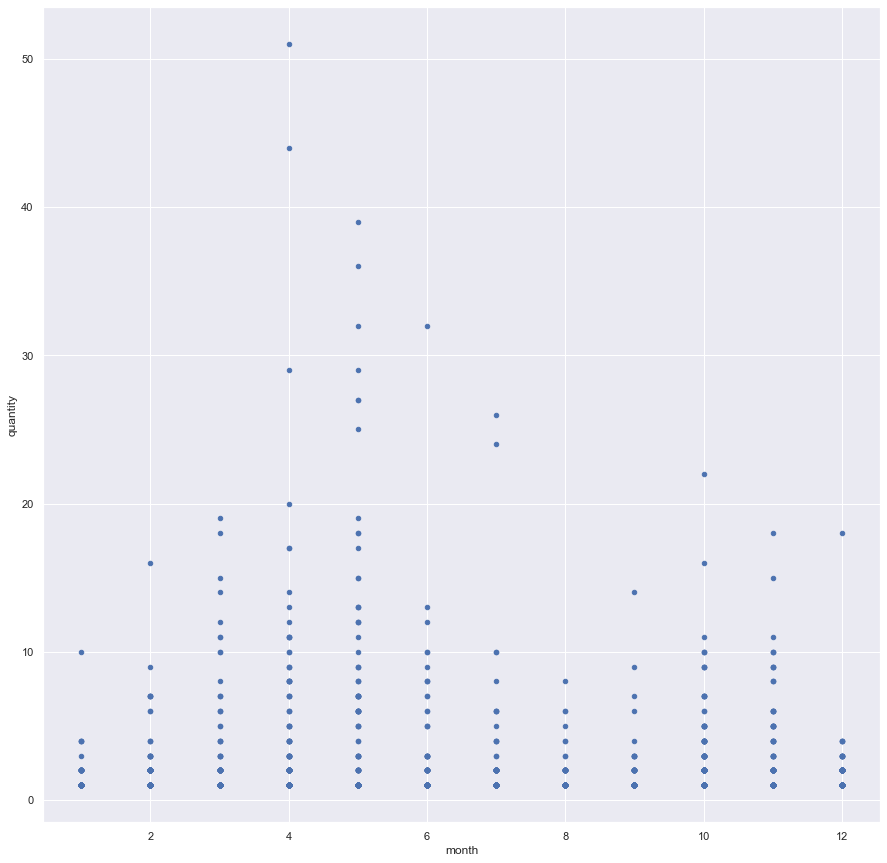

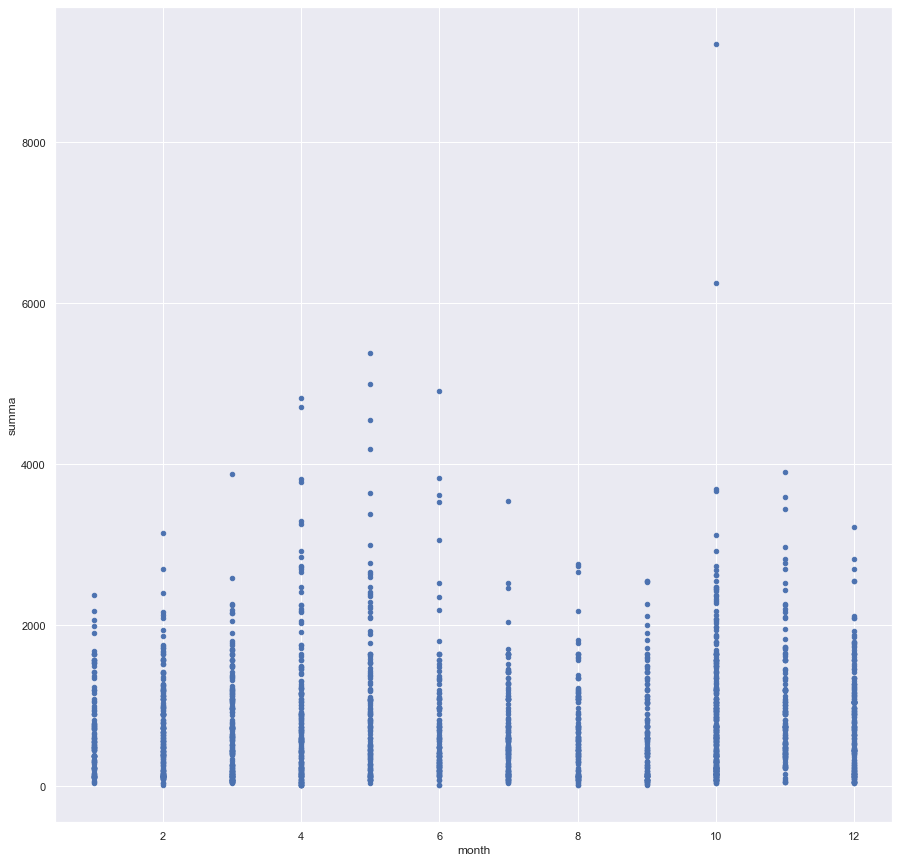

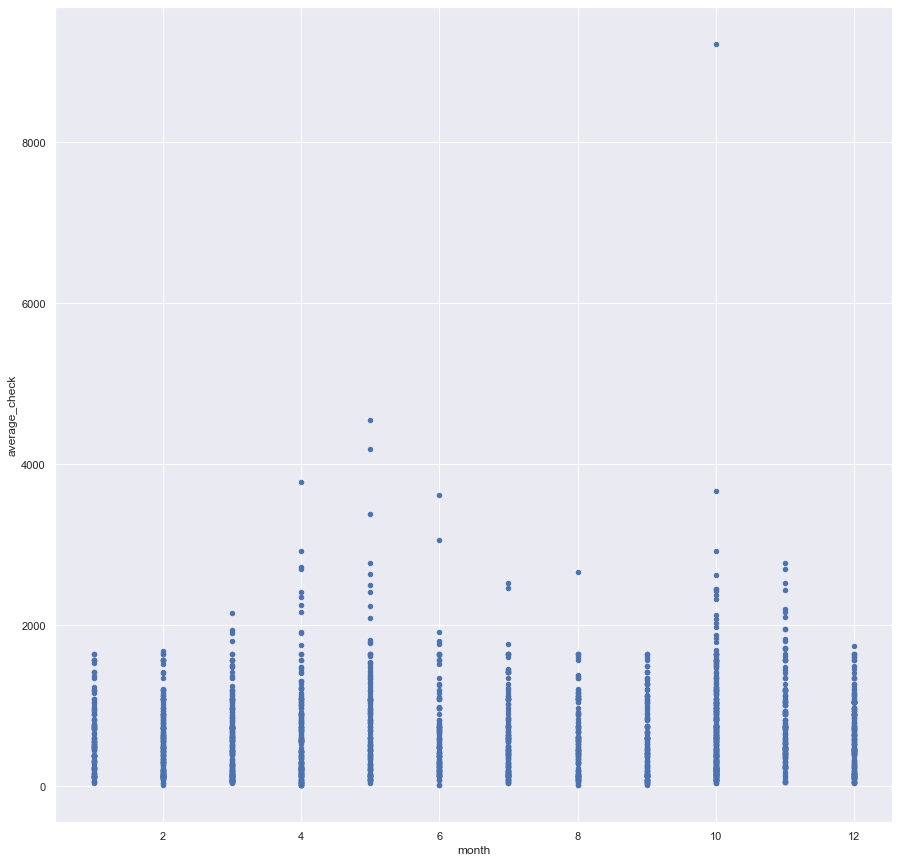

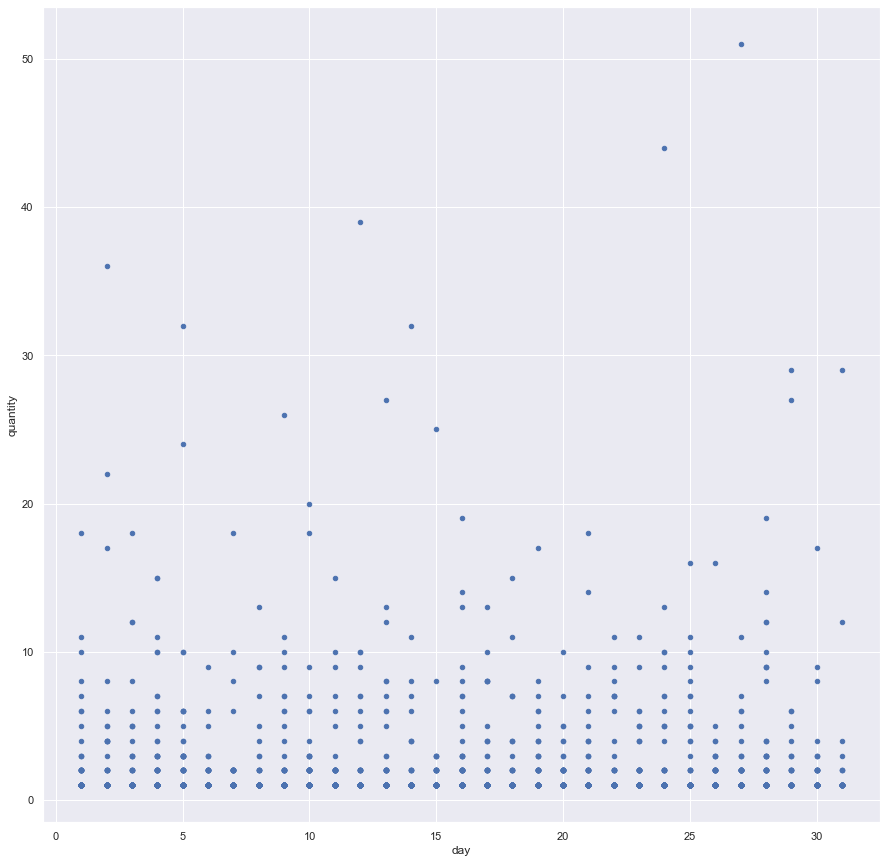

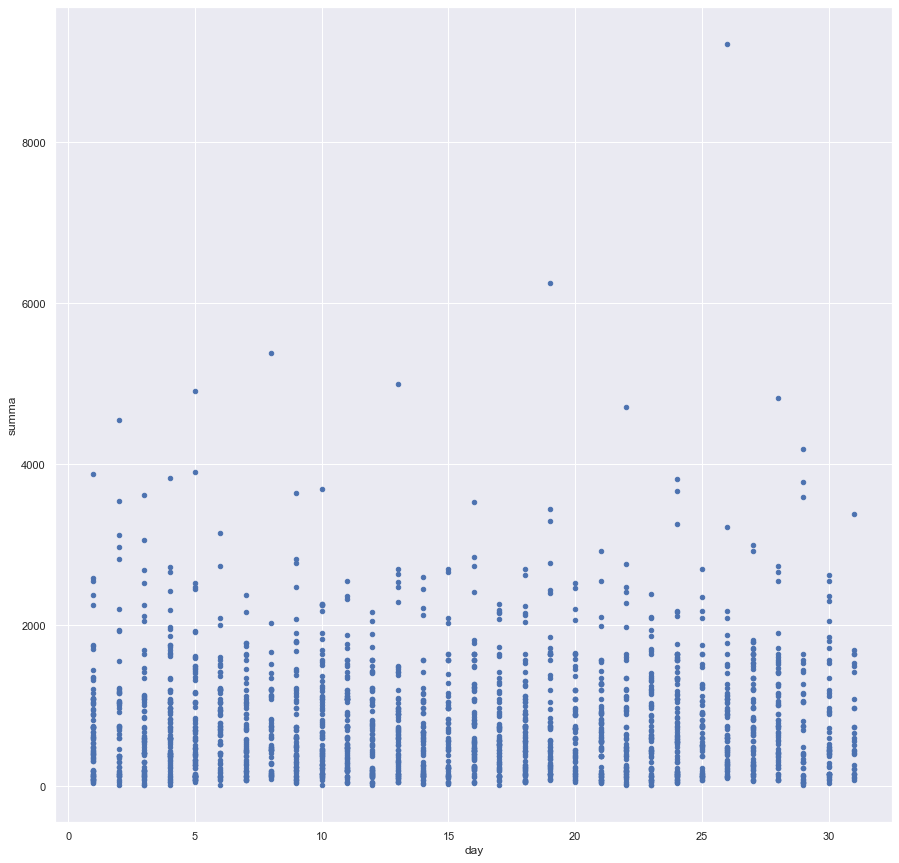

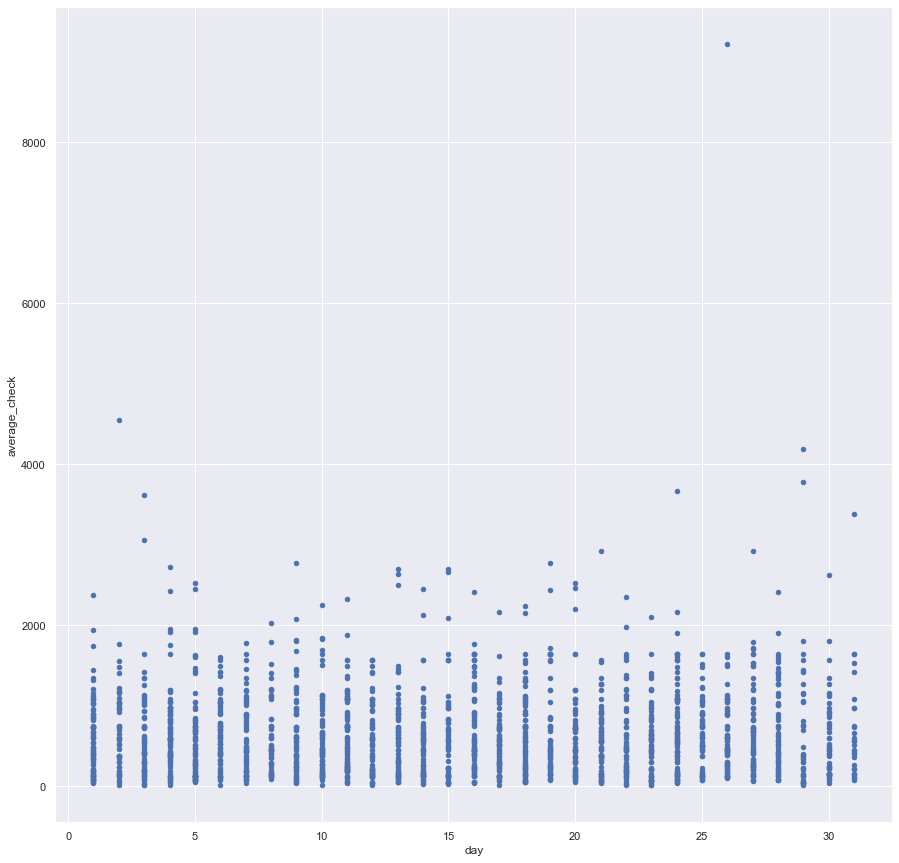

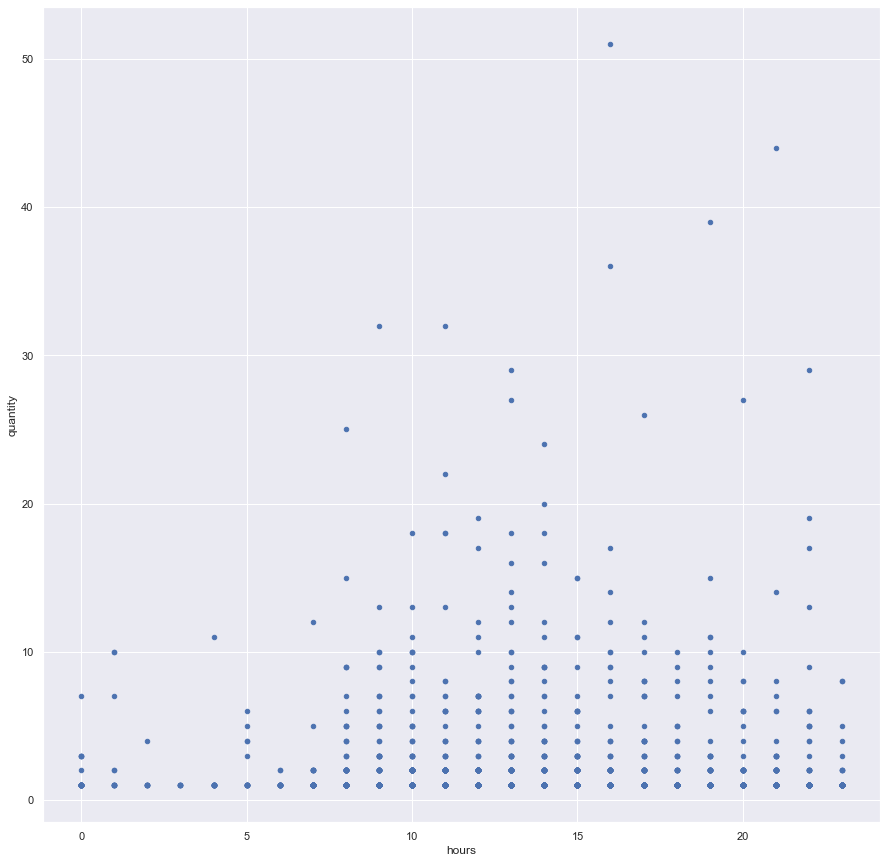

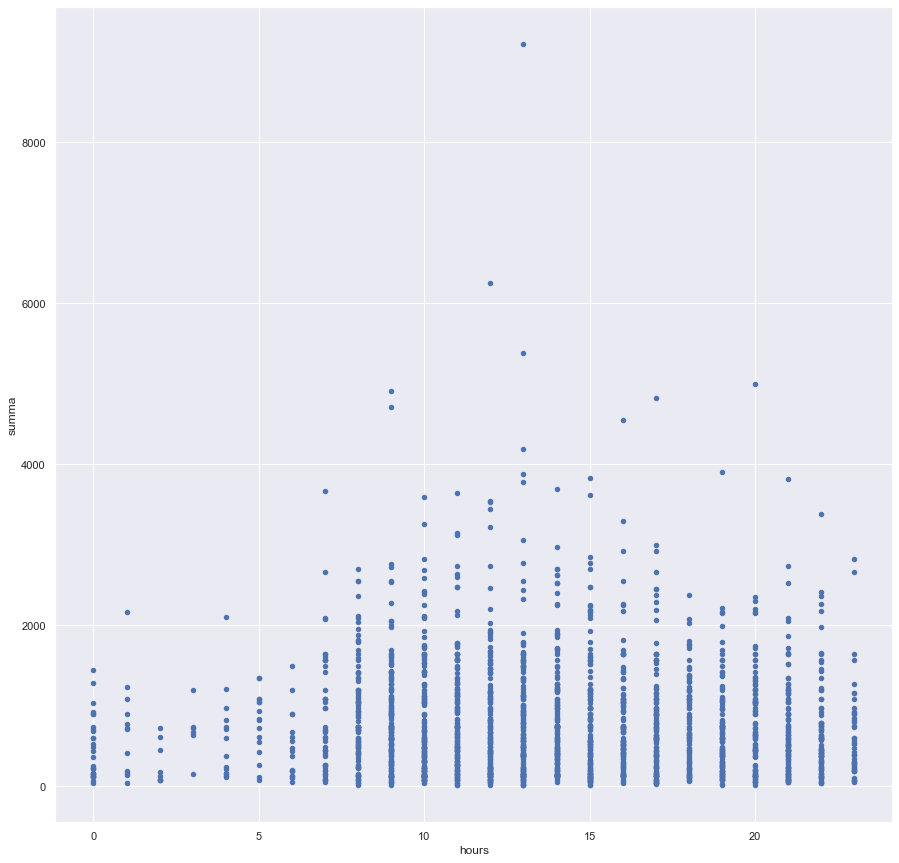

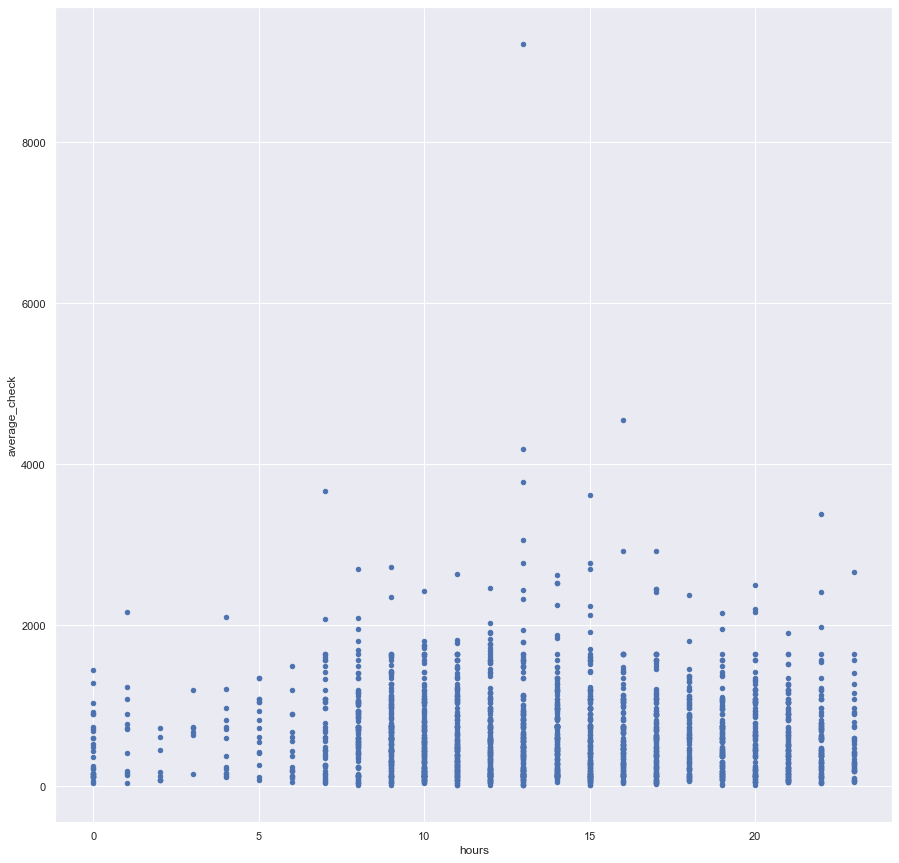

In [1275]:
for a in name_date:
    for f in name_columns:
        data_hours.plot(x= a, y=f, kind='scatter')

Выводы
----
   1. При реализации продукции наблюдается сезонность по месяцам: 
      - лучше всего товары интернет-магазина "Пока все ещё тут" продаются в период с апреля по июнь и сентябрь по ноябрь
      - худшими месяцами для продажи являются декабрь, январь, август.
   2. Анализ проверки периодичности реализации продукции в месяц не выявлено. 
   3. Анализ активности пользователей в течении суток показал:
      - активное функционирование покупателей время покупок приходится на время с 8.00 до 19.00 
      - на 01.00-4.00 приходится наименьшее время покупок
      - наиболее большей объем приходится на время с 10.00 до 17.00
   4. На размер среднего чека влияет __Сезонность__ по месяцам
      

# Хоть вы сказали и не надо делать, но мне стало интересно провести когортный анализ распределения доходов по месяцам

Когортный анализ на удержании клиентов

In [1276]:
first_order_date_by_customers = data_corr.groupby('customer_id')['date'].min() 

In [1277]:
data_corr.head()

,date,customer_id,order_id,product,quantity,price,del,summa,date_all,month,day,hours
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,68477,142.0,2018-10-01,10,1,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,68477,194.0,2018-10-01,10,1,0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,68477,112.0,2018-10-01,10,1,0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,68477,179.0,2018-10-01,10,1,0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,68477,112.0,2018-10-01,10,1,0


In [1278]:
first_order_date_by_customers.name = 'first_order_date'

In [1279]:
data_corr = data_corr.join(first_order_date_by_customers,on='customer_id')

In [1280]:
data_corr['first_order_month'] = data_corr['first_order_date'].astype('datetime64[M]')
data_corr['order_month'] = data_corr['date'].astype('datetime64[M]')

In [1281]:
orders_grouped_by_cohorts = data_corr.groupby(['first_order_month', 'order_month']).agg({'customer_id':'nunique','summa':'sum'}).reset_index()

In [1282]:
orders_grouped_by_cohorts.head()

,first_order_month,order_month,customer_id,summa
0,2018-10-01,2018-10-01,152,183399.0
1,2018-10-01,2018-11-01,1,11424.0
2,2018-10-01,2018-12-01,1,20788.0
3,2018-10-01,2019-01-01,3,2393.0
4,2018-10-01,2019-02-01,1,12673.0


In [1283]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['summa'] / orders_grouped_by_cohorts['customer_id']

In [1284]:
orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['order_month'] -  orders_grouped_by_cohorts['first_order_month'])/ np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

In [1285]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')

In [1286]:
inital_users_count_month = orders_grouped_by_cohorts[orders_grouped_by_cohorts['cohort_lifetime'] == 0][['first_order_month','customer_id']]
inital_users_count_month = inital_users_count_month.rename(columns={'customer_id':'cohort_users_month'})

In [1287]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.merge(inital_users_count_month,on='first_order_month')

In [1288]:
orders_grouped_by_cohorts['retention'] = orders_grouped_by_cohorts['customer_id'] /orders_grouped_by_cohorts['cohort_users_month']
retention_pivot_month = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

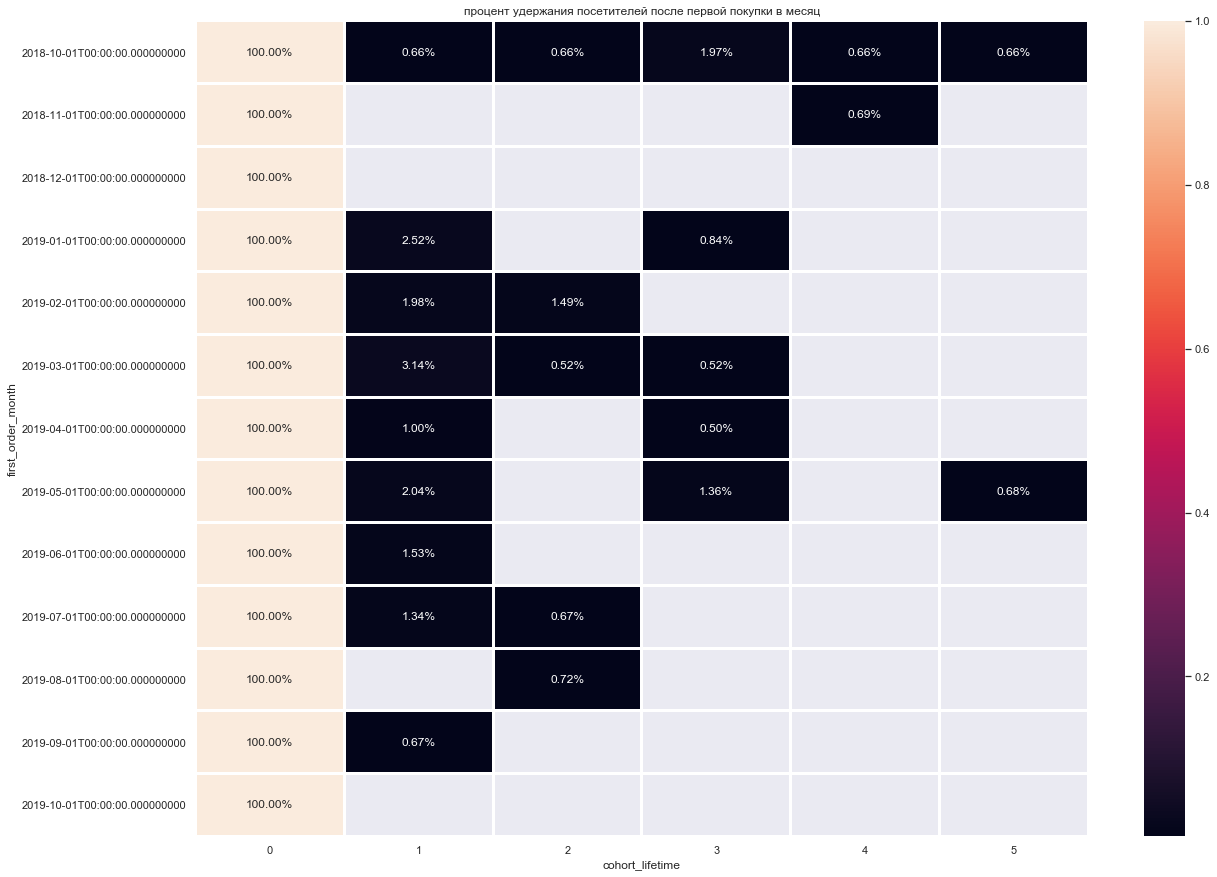

In [1289]:
plt.figure(figsize=(20, 15))
plt.title('процент удержания посетителей после первой покупки в месяц')
sns.heatmap(retention_pivot_month, annot=True, fmt='.2%', linewidths=2, linecolor='white')

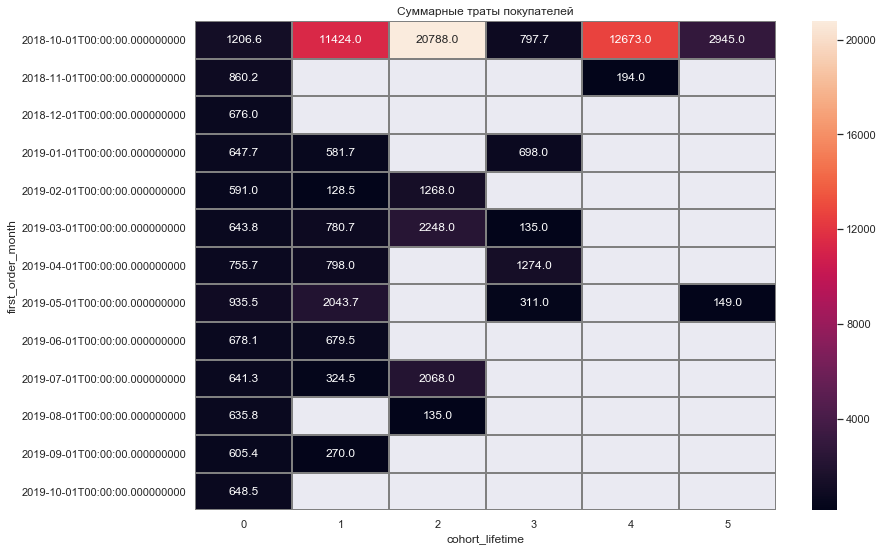

In [1290]:
plt.figure(figsize=(13, 9))
plt.title('Суммарные траты покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

Вывод 
-----
   1. У предприятия небольшей процент удержание клиентов. 
   2. Клиенты, которые удержаны приносят больший доход чем они тратили на первоначальном этапе. Особенно это видно по октяборьской и февральской и апрельской когортах.
   3. Первоначальный средний уровень трат на продукцию интернет магазина падает на протяжении года.
    

Резюме о проделанной работе
-----
- Исследован какой объем покупок осуществляли покупатели в разрезе суток, часов и месяцев;
- Проведен анализ среднего чека по пользователям;
- Проведен когортный анализ на удержании клиентов
- Проанализировано изменение тра клиентов при повторных покупках


Выводы
-----
   1. При реализации продукции наблюдается сезонность по месяцам: 
      - лучше всего товары интернет-магазина "Пока все ещё тут" продаются в период с марта по июнь и сентябрь по ноябрь
      - худшими месяцами для продажи являются декабрь, январь, август.
   2. Анализ проверки периодичности реализации продукции в месяц не выявлено. 
   3. анализ активности пользователей в течении суток показал:
      - активное функционирование покупателей время покупок приходится на время с 8.00 до 19.00 
      - на 01.00-4.00 приходится наименьшее время покупок
      - наиболее большей объем приходится на время с 10.00 до 14.00
   4. На размер среднего чека влияет __Сезонность__ по месяцам
   5. У предприятия небольшой процент удержание клиентов. 
   6. Клиенты, которые удержаны приносят больший доход чем они тратили на первоначальном этапе. Особенно это видно по октябрьской, февральской и апрельской когортах.
   7. Первоначальный средний уровень трат на продукцию интернет магазина падает на протяжении года.


------

# Шаг 3. Сегментация покупателей на основе истории их покупок

------

- ABC анализ по объему трат
- Анализ покупателей по количеству покупок

In [1291]:
data_corr.head()

,date,customer_id,order_id,product,quantity,price,del,summa,date_all,month,day,hours,first_order_date,first_order_month,order_month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,68477,142.0,2018-10-01,10,1,0,2018-10-01,2018-10-01,2018-10-01
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,68477,194.0,2018-10-01,10,1,0,2018-10-01,2018-10-01,2018-10-01
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,68477,112.0,2018-10-01,10,1,0,2018-10-01,2018-10-01,2018-10-01
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,68477,179.0,2018-10-01,10,1,0,2018-10-01,2018-10-01,2018-10-01
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,68477,112.0,2018-10-01,10,1,0,2018-10-01,2018-10-01,2018-10-01


In [1292]:
data_ABC = data_corr.pivot_table('summa', index='customer_id', columns='order_month', margins=True).reset_index()
data_ABC.columns = ['customer_id', '2018_10', '2018_11', '2018_12', '2019_01', '2019_02', '2019_03', '2019_04', '2019_05', '2019_06', '2019_07', '2019_08', '2019_09', '2019_10', 'All']

In [1293]:
data_ABC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 15 columns):
customer_id    2057 non-null object
2018_10        153 non-null float64
2018_11        147 non-null float64
2018_12        194 non-null float64
2019_01        123 non-null float64
2019_02        207 non-null float64
2019_03        198 non-null float64
2019_04        212 non-null float64
2019_05        151 non-null float64
2019_06        136 non-null float64
2019_07        153 non-null float64
2019_08        144 non-null float64
2019_09        151 non-null float64
2019_10        143 non-null float64
All            2057 non-null float64
dtypes: float64(14), object(1)
memory usage: 241.1+ KB


In [1294]:
data_ABC.head()

,customer_id,2018_10,2018_11,2018_12,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,2019_07,2019_08,2019_09,2019_10,All
0,000d6849-084e-4d9f-ac03-37174eaf60c4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.75,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,NaN,NaN,NaN,NaN,442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914.00,914.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,NaN,NaN,NaN,1649.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1649.00
4,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,NaN,NaN,NaN,1536.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1536.00


In [1295]:
data_ABC['means']=data_ABC[['2018_10', '2018_11', '2018_12', '2019_01', '2019_02', '2019_03', '2019_04', '2019_05', '2019_06', '2019_07', '2019_08', '2019_09', '2019_10']].mean(axis=1)
data_ABC['count']=data_ABC[['2018_10', '2018_11', '2018_12', '2019_01', '2019_02', '2019_03', '2019_04', '2019_05', '2019_06', '2019_07', '2019_08', '2019_09', '2019_10']].count(axis=1)

In [1296]:
data_ABC.head()

,customer_id,2018_10,2018_11,2018_12,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,2019_07,2019_08,2019_09,2019_10,All,means,count
0,000d6849-084e-4d9f-ac03-37174eaf60c4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.75,138.75,138.75,1
1,001cee7f-0b29-4716-b202-0042213ab038,NaN,NaN,NaN,NaN,442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442.00,442.00,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,914.00,914.00,914.00,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,NaN,NaN,NaN,1649.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1649.00,1649.00,1
4,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,NaN,NaN,NaN,1536.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1536.00,1536.00,1


In [1297]:
data_ABC.groupby('count').agg({'customer_id': 'count'})

,customer_id
count,
1,2021
2,30
3,4
6,1
13,1


Вывод
-----
   1. Можно выделить две крупные группы клиентов:
      - Клиенты которые совершили 1 сделку;
      - Клиенты которые совершили 2 и более сделок.

Разделим группу DF на две группы и проанализируем их
  

In [1298]:
data_ABC_1 = data_ABC[data_ABC['count'] == 1]
data_ABC_2 = data_ABC[data_ABC['count'] > 1]

In [1299]:
data_ABC_2['All_summ'] = data_ABC_2['All'] * data_ABC_2['count']

D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1300]:
summa_1 = data_ABC_1['All'].sum()
summa_2 = data_ABC_2['All_summ'].sum()


In [1301]:
data_ABC_1['share'] = 100 * data_ABC_1['All'] / summa_1
data_ABC_2['share'] = 100 * data_ABC_2['All_summ'] / summa_2


D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1302]:
data_ABC_1 = data_ABC_1.sort_values(by = 'share', ascending = False)
data_ABC_2 = data_ABC_2.sort_values(by = 'share', ascending = False)


In [1303]:
data_ABC_1['share_cumsum'] = data_ABC_1['share'].cumsum() 
data_ABC_2['share_cumsum'] = data_ABC_2['share'].cumsum() 


In [1304]:
def aaa(data_1):
    share_cumsum = data_1['share_cumsum'] 
    if share_cumsum <= 80:
        return 'A'
    if (share_cumsum > 80) and (share_cumsum <= 95):
        return 'B'
    if share_cumsum > 95:
        return 'C'

In [1305]:
data_ABC_1['A_B_C'] = data_ABC_1.apply(aaa, axis=1)
data_ABC_2['A_B_C'] = data_ABC_2.apply(aaa, axis=1)


In [1306]:
final_data_ABC_1 = data_ABC_1.groupby('A_B_C').agg({'customer_id': 'count'})

In [1307]:
final_data_ABC_1['share'] = final_data_ABC_1['customer_id'] / final_data_ABC_1['customer_id'].sum()

In [1308]:
final_data_ABC_1

,customer_id,share
A_B_C,,
A,936,0.463137
B,578,0.285997
C,507,0.250866


In [1309]:
A_B_C = ['A', 'B', 'C']


In [1310]:
for elements in A_B_C:
    print('Группа', elements)
    print(data_ABC_1[data_ABC_1['A_B_C'] == elements]['All'].describe())
    print()
    

Группа A
count     936.000000
mean      905.024326
std       349.081467
min       449.000000
25%       600.000000
50%       824.000000
75%      1087.000000
max      1649.000000
Name: All, dtype: float64

Группа B
count    578.000000
mean     274.746075
std       91.857389
min      150.000000
25%      194.000000
50%      254.000000
75%      368.625000
max      449.000000
Name: All, dtype: float64

Группа C
count    507.000000
mean     104.515574
std       36.415058
min       14.000000
25%       74.000000
50%      114.571429
75%      134.000000
max      150.000000
Name: All, dtype: float64



Из анализа видно:
   1. Клинеты из группы А занимают 47,86% от всех клиентов, совершивших одну сделку, и приносят 80% выручки от клиентов совершивших одну сделку. Минимальный закупки составляют 449 у.е. Максимальный объем закупок 1649 у.е.
   2. Клиенты из группы В занимают 29,2% и приносят 15% выручки. Минимальный закупки составляют 150 у.е. Максимальный объем закупок 449 у.е.
   3. Группа С занимают 22,94% и приносят 5% выручки. Минимальный закупки составляют 14 у.е. Максимальный объем закупок 150 у.е.

# Для клиентов которые совершат 2 и более сделки дополнительно сделаем XYZ-анализ

In [1311]:
data_ABC_2['vars']=data_ABC_2[['2018_10', '2018_11', '2018_12', '2019_01', '2019_02', '2019_03', '2019_04', '2019_05', '2019_06', '2019_07', '2019_08', '2019_09', '2019_10']].var(axis=1)


In [1312]:
data_ABC_2['coefficient_variation'] = (data_ABC_2['vars']**0.5)*100 / data_ABC_2['means']

In [1313]:
data_ABC_2.head()

,customer_id,2018_10,2018_11,2018_12,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,...,2019_10,All,means,count,All_summ,share,share_cumsum,A_B_C,vars,coefficient_variation
2056,All,429.505855,359.229551,579.142308,522.848684,428.846154,337.653333,250.513219,199.390691,333.670175,...,498.32967,360.852080,405.538426,13,4691.077046,15.868114,15.868114,A,12464.718967,27.530192
1596,c971fb21-d54c-4134-938f-16b62ee86d3b,666.571429,439.384615,611.411765,438.000000,633.650000,490.833333,NaN,NaN,NaN,...,NaN,572.792793,546.641857,6,3436.756757,11.625230,27.493344,A,10514.084063,18.757841
1804,e323e5c3-7b2c-4558-8e76-34698e0b2946,NaN,NaN,NaN,NaN,NaN,NaN,1274.000000,NaN,NaN,...,NaN,1274.000000,1274.000000,2,2548.000000,8.618906,36.112250,A,0.000000,0.000000
1997,f909dc01-f7f6-4217-a842-958e0d06c9f4,NaN,NaN,NaN,NaN,1498.000000,NaN,598.000000,NaN,NaN,...,NaN,1048.000000,1048.000000,2,2096.000000,7.089964,43.202214,A,405000.000000,60.724819
1844,e8204583-4d55-4724-ad3f-049c7db43bdd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1034.000000,1034.000000,2,2068.000000,6.995251,50.197465,A,0.000000,0.000000


In [1314]:
def vars(data_1):
    share_cumsum = data_1['coefficient_variation'] 
    if share_cumsum <= 10:
        return 'X'
    if (share_cumsum > 10) and (share_cumsum <= 25):
        return 'Y'
    if share_cumsum > 25:
        return 'Z'

In [1315]:
data_ABC_2['X_Y_Z'] = data_ABC_2.apply(vars, axis=1)


In [1316]:
final_data_ABC_2 = data_ABC_2.groupby(['A_B_C', 'X_Y_Z']).agg({'customer_id': 'count'})

In [1317]:
final_data_ABC_2

customer_id
A_B_C X_Y_Z             
A     X                2
      Y                4
      Z               11
B     X                3
      Y                1
      Z                7
C     X                2
      Y                3
      Z                3

Вывод
----
   1. В ходе анализа у нас получилось 9 групп, которые можно объединить в 3 группы:
      - Сегмент 1: AX, AY, BX
      - Сегмент 2: AZ, BY, CX
      - Сегмент 3: BZ, CY, CZ
   2. Все эти группы покупателей важны для нас и требуют чуткого взаимодействия с ними, т.к. осуществляют большей объем закупок.
   3. Самой важным сегментом для нас явлется сегмент 1, с данной группой покупателей необходимо выстраивать взаимоотношения. 


In [1318]:
X_Y_Z = ['X', 'Y', 'Z']  

In [1319]:
for elements in A_B_C:
    for elemnts_X in X_Y_Z:
        print('Группа', elements, elemnts_X)
        print('сумма продажи')
        print(data_ABC_2[(data_ABC_2['A_B_C'] == elements) & (data_ABC_2['X_Y_Z'] == elemnts_X)]['All_summ'].describe())
        print()
        print('количество сделок')
        print(data_ABC_2[(data_ABC_2['A_B_C'] == elements) & (data_ABC_2['X_Y_Z'] == elemnts_X)]['count'].describe())

        print()
        print()

Группа A X
сумма продажи
count       2.000000
mean     2308.000000
std       339.411255
min      2068.000000
25%      2188.000000
50%      2308.000000
75%      2428.000000
max      2548.000000
Name: All_summ, dtype: float64

количество сделок
count    2.0
mean     2.0
std      0.0
min      2.0
25%      2.0
50%      2.0
75%      2.0
max      2.0
Name: count, dtype: float64


Группа A Y
сумма продажи
count       4.000000
mean     1472.875697
std      1336.729972
min       625.333333
25%       628.726190
50%       914.706349
75%      1758.855856
max      3436.756757
Name: All_summ, dtype: float64

количество сделок
count    4.0
mean     3.0
std      2.0
min      2.0
25%      2.0
50%      2.0
75%      3.0
max      6.0
Name: count, dtype: float64


Группа A Z
сумма продажи
count      11.000000
mean     1182.302080
std      1245.469064
min       448.000000
25%       598.906250
50%       717.000000
75%       897.666667
max      4691.077046
Name: All_summ, dtype: float64

количество сделок
cou

Выводы:
-----
   1. Клиенты из группы АХ: минимальная стоимость закупки - 2068 у.е., максимальная сумма покупок 2548 у.е. В основном клиенты из данной группы совершают 2 сделки.
   2. Клиенты из группы АY: минимальная стоимость закупки - 625 у.е., максимальная сумма покупок 3436 у.е.  основном клиенты из данной группы совершают 2 сделки.
   3. Клиенты из группы АZ: минимальная стоимость закупки - 448 у.е., максимальная сумма покупок 4691 у.е. В основном клиенты из данной группы совершают 2 сделки.
   4. Клиенты из группы ВХ: минимальная стоимость закупки - 414 у.е., максимальная сумма покупок 432 у.е. Более 50% из данной группы совершают 3 сделки, оставшиеся 3 сделки.
   5. Клиенты из группы ВY: минимальная стоимость закупки - 359.е., максимальная сумма покупок 359 у.е. Клиенты совершают 2 сделки.
   6. Клиенты из группы ВZ: минимальная стоимость закупки - 342.е., максимальная сумма покупок 429 у.е.  В основном клиенты из данной группы совершают 2 сделки.
   7. Клиенты из группы CХ: минимальная стоимость закупки - 276.е., максимальная сумма покупок 283 у.е. Клиенты совершают 2 сделки.
   8. Клиенты из группы CY: минимальная стоимость закупки - 162.е., максимальная сумма покупок 310 у.е. Клиенты совершают 2 сделки.
   9. Клиенты из группы СZ: минимальная стоимость закупки - 81.е., максимальная сумма покупок 208 у.е.  В основном клиенты из данной группы совершают 2 сделки.

Резюме о проделанной работе
-----
  1. Разделены пользователи на группы, которые совершили одну сделку, и группы, которые совершили 2 и более сделок.
  2. Проведен АВС-анализ пользователей, которые совершили 1 сделку
  3. Проведен ABC и XYZ-анализ пользователей, которые совершили 2 и более сделки
  4. Выделены сегменты и подсигменты


Выводы
-----
   1. Для клентов совершивших 1 сделку:
        1. Клинеты из группы А занимают 47,86% от всех клиентов, совершивших одну сделку, и приносят 80% выручки от клиентов совершивших одну сделку. Минимальный закупки составляют 375 у.е. Максимальный объем закупок 1319 у.е.
        2. Клиенты из группы В занимают 29,2% и приносят 15% выручки. Минимальный закупки составляют 142 у.е. Максимальный объем закупок 375 у.е.
        3. Группа С занимают 22,94% и приносят 5% выручки. Минимальный закупки составляют 14 у.е. Максимальный объем закупок 142 у.е.
   2. Для клиентов совершивших 2 и более сделки:
         1. В ходе анализа у нас получилось 9 групп, которые можно объединить в 3 группы:
            - Сегмент 1: AX, AY, BX. MIN объем закупки (суммарный) - 414 у.е., MAX объем закупки (суммарный) - 2548 у.е.
            - Сегмент 2: AZ, BY, CX. MIN объем закупки (суммарный) - 276 у.е., MAX объем закупки (суммарный) - 4691 у.е., клиенты совершают 2 сделки.
            - Сегмент 3: BZ, CY, CZ. MIN объем закупки (суммарный) - 81 у.е., MAX объем закупки (суммарный) - 429 у.е., клиенты совершают 2 сделки.
         2. Все эти группы покупателей важны для нас и требуют чуткого взаимодействия с ними, т.к. осуществляют большей объем закупок.
         3. Самой важным сегментом для нас явлется сегмент 1, с данной группой покупателей необходимо выстраивать взаимоотношения. 


In [1320]:
data_AX = data_ABC_2[(data_ABC_2['A_B_C'] == 'A') & (data_ABC_2['X_Y_Z'] == 'X')]
data_AY =data_ABC_2[(data_ABC_2['A_B_C'] == 'A') & (data_ABC_2['X_Y_Z'] == 'Y')]
data_BX =data_ABC_2[(data_ABC_2['A_B_C'] == 'B') & (data_ABC_2['X_Y_Z'] == 'X')]


In [1321]:
for customer_id in data_AX['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

2990    Весы электронные кухонные Soehnle (круглые,20 ...
5988    Весы электронные кухонные Soehnle (круглые,20 ...
Name: product, dtype: object

5939    Мединилла Магнифика d-17 см h-60 см
6234    Мединилла Магнифика d-17 см h-60 см
6272    Мединилла Магнифика d-17 см h-60 см
Name: product, dtype: object



In [1322]:
for customer_id in data_AY['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

9       Чехол для гладильной доски Colombo Persia Beig...
20      Чехол для гладильной доски Festival 137x60 см ...
64      Набор прищепок большие пластиковые ROZENBAL ПИ...
65      Сушилка для белья Attribute ПРИМА 11 м синяя н...
130     Тележка багажная DELTA ТБР-20 коричневый с ора...
131     Готовая скатерть Ажурная Dia Rose круглая д.15...
132     Сушилка для белья потолочная Zalger Lift Basic...
139     Таз пластмассовый 18,0 л квадратный (ТП-18) "П...
160           Стяжка оконная с болтом СТ-55 цинк, 1108354
171     Сумка-тележка 3-х колесная Gimi Tris Floral синяя
172     Сумка-тележка хозяйственная Andersen Scala Sho...
183     Герань домашняя (пеларгония зональная) цветуща...
184     Герань домашняя (пеларгония зональная) цветуща...
185     Герань домашняя (пеларгония зональная) цветуща...
186     Герань домашняя (пеларгония зональная) цветуща...
187     Декоративная композиция искуственных цветов Бу...
188     Искусственный цветок Роза бархатная с закрытым...
257     Чехол 

In [1323]:
for customer_id in data_BX['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

2452    Пеларгония зональная диам. 12 см сиреневый пол...
2453    Пеларгония розебудная Margaretha укорененный ч...
2454       Пеларгония розебудная Mary укорененный черенок
2455    Пеларгония розебудная Prins Nikolai укорененны...
2456    Пеларгония розебудная Queen Ingrid укорененный...
2457    Пеларгония розебудная Red Pandora укорененный ...
2818    Пеларгония зональная диам. 12 см сиреневый пол...
2819             Пеларгония зональная простая цвет фуксии
5163                       Пеларгония тюльпановидная EMMA
Name: product, dtype: object

2293    Коврик придверный хлопковый 55х110 см мультико...
2583    Коврик придверный хлопковый 55х110 см мультико...
Name: product, dtype: object

1488      Пеларгония зональная диам. 12 см белая махровая
1489    Пеларгония зональная диам. 12 см коралловая по...
1490    Пеларгония зональная диам. 12 см красный махровый
1491    Пеларгония зональная диам. 12 см лососевая мах...
1492    Пеларгония зональная диам. 12 см розово-красна...
1493    Пела

In [1324]:
data_AZ = data_ABC_2[(data_ABC_2['A_B_C'] == 'A') & (data_ABC_2['X_Y_Z'] == 'Z')]
data_BY =data_ABC_2[(data_ABC_2['A_B_C'] == 'B') & (data_ABC_2['X_Y_Z'] == 'Y')]
data_CX =data_ABC_2[(data_ABC_2['A_B_C'] == 'C') & (data_ABC_2['X_Y_Z'] == 'X')]


In [1325]:
for customer_id in data_AZ['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

Series([], Name: product, dtype: object)

1713    Кофр для хранения Hausmann средний 36х36х30 2 ...
2816    Чехол для одежды объемный Hausmann с овальным ...
Name: product, dtype: object

1507    Контейнер для СВЧ Полимербыт Премиум 1,2 л 435...
1508    Контейнер для СВЧ Полимербыт Премиум 1,2 л 435...
1807         Стремянка металлическая 3 ступени, СМ3, НИКА
Name: product, dtype: object

3349                      Калла крупноцветковая малиновая
3386                      Калла крупноцветковая малиновая
3387                      Калла крупноцветковая малиновая
3388                      Калла крупноцветковая малиновая
3393                      Калла крупноцветковая малиновая
3394                      Калла крупноцветковая малиновая
3395                      Калла крупноцветковая малиновая
6077    Пеларгония розебудная Red Pandora укорененный ...
Name: product, dtype: object

1941    Чехол для гладильной доски Colombo Persia Beig...
2077    Подкладка под чехол Zalger 520114 135х50 см во..

In [1326]:
for customer_id in data_BY['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

5102    Пеларгония зональная диам. 12 см сиренево-крас...
5103    Пеларгония зональная диам. 12 см сиреневый пол...
5104    Пеларгония зональная диам. 12 см ярко красная ...
5105    Пеларгония зональная диам. 12 см ярко розовая ...
5106             Пеларгония зональная простая цвет фуксии
5107    Пеларгония розебудная Prins Nikolai укорененны...
5108    Пеларгония Toscana Angeleyes Bicolor укорененн...
5625    Пеларгония зональная диам. 12 см красная махровая
5626    Пеларгония зональная диам. 12 см розовая махровая
5627    Пеларгония зональная диам. 12 см сиреневый пол...
5628    Пеларгония зональная диам. 12 см ярко красная ...
5629             Пеларгония зональная простая цвет фуксии
5630    Пеларгония розебудная Prins Nikolai укорененны...
Name: product, dtype: object



In [1327]:
for customer_id in data_BX['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

2452    Пеларгония зональная диам. 12 см сиреневый пол...
2453    Пеларгония розебудная Margaretha укорененный ч...
2454       Пеларгония розебудная Mary укорененный черенок
2455    Пеларгония розебудная Prins Nikolai укорененны...
2456    Пеларгония розебудная Queen Ingrid укорененный...
2457    Пеларгония розебудная Red Pandora укорененный ...
2818    Пеларгония зональная диам. 12 см сиреневый пол...
2819             Пеларгония зональная простая цвет фуксии
5163                       Пеларгония тюльпановидная EMMA
Name: product, dtype: object

2293    Коврик придверный хлопковый 55х110 см мультико...
2583    Коврик придверный хлопковый 55х110 см мультико...
Name: product, dtype: object

1488      Пеларгония зональная диам. 12 см белая махровая
1489    Пеларгония зональная диам. 12 см коралловая по...
1490    Пеларгония зональная диам. 12 см красный махровый
1491    Пеларгония зональная диам. 12 см лососевая мах...
1492    Пеларгония зональная диам. 12 см розово-красна...
1493    Пела

In [1328]:
data_BY = data_ABC_2[(data_ABC_2['A_B_C'] == 'B') & (data_ABC_2['X_Y_Z'] == 'Y')]
data_CY =data_ABC_2[(data_ABC_2['A_B_C'] == 'C') & (data_ABC_2['X_Y_Z'] == 'Y')]
data_CZ =data_ABC_2[(data_ABC_2['A_B_C'] == 'C') & (data_ABC_2['X_Y_Z'] == 'Z')]

In [1329]:
for customer_id in data_BY['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

5102    Пеларгония зональная диам. 12 см сиренево-крас...
5103    Пеларгония зональная диам. 12 см сиреневый пол...
5104    Пеларгония зональная диам. 12 см ярко красная ...
5105    Пеларгония зональная диам. 12 см ярко розовая ...
5106             Пеларгония зональная простая цвет фуксии
5107    Пеларгония розебудная Prins Nikolai укорененны...
5108    Пеларгония Toscana Angeleyes Bicolor укорененн...
5625    Пеларгония зональная диам. 12 см красная махровая
5626    Пеларгония зональная диам. 12 см розовая махровая
5627    Пеларгония зональная диам. 12 см сиреневый пол...
5628    Пеларгония зональная диам. 12 см ярко красная ...
5629             Пеларгония зональная простая цвет фуксии
5630    Пеларгония розебудная Prins Nikolai укорененны...
Name: product, dtype: object



In [1330]:
for customer_id in data_CY['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

911     Герань домашняя (пеларгония зональная) цветуща...
912     Герань домашняя (пеларгония зональная) цветуща...
913     Герань домашняя (пеларгония зональная) цветуща...
914     Герань домашняя (пеларгония зональная) цветуща...
915     Герань домашняя (пеларгония зональная) цветуща...
916     Герань домашняя (пеларгония зональная) цветуща...
2146         Разделочная доска Классика О-35 35х21х1,5 см
Name: product, dtype: object

6145    Пеларгония зональная диам. 12 см сиреневый пол...
6146       Пеларгония розебудная Mary укорененный черенок
6147    Пеларгония розебудная Prins Nikolai укорененны...
6148                       Пеларгония тюльпановидная EMMA
6196                       Пеларгония тюльпановидная EMMA
6197    Флокс метельчатый сорт Мари, диаметр горшка 10см.
6198    Флокс метельчатый сорт Морской петух Новый сор...
6199    Флокс метельчатый сорт ПОЛИНА, диаметр горшка ...
6200    Флокс метельчатый сорт Чурленис, диаметр горшк...
6542       Пеларгония розебудная Mary укор

In [1331]:
for customer_id in data_CZ['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

2574    Пеларгония зональная Ринго Вайт d-7 см h-10 см...
2579    Пеларгония розебудная Prins Nikolai укорененны...
Name: product, dtype: object

2602    Бакопа ампельная махровая сиреневая махровая о...
2603    Бакопа ампельная махровая фиолетовая махровая ...
2604    Виола рассада однолетних цветов в кассете по 1...
2605    Газания рассада однолетних цветов в кассете по...
2606    Калибрахоа Aloha Double Purple сиреневая махро...
2607    Калибрахоа Aloha Kona Pineaple желто-красная о...
2608     Калибрахоа Aloha Tiki Neon малиновая объем 0,5 л
2609    Калибрахоа Bloomtastic Blossom розово-сиренева...
2610    Калибрахоа Mini Famous Double Red красная махр...
2611    Калибрахоа Rave Violet сиреневая звезда объем ...
2612    Калибрахоа Sweet Bells Double Golden желтая ма...
2613    Львиный зев рассада однолетних цветов в кассет...
2614    Петуния Surprice Yellow желтая с прожилками об...
2615     Петуния Sweetunia Black Satin черная объем 0,5 л
2616    Рассада томата (помидор) Баскью Бл

In [1332]:
data_A = data_ABC_1[(data_ABC_1['A_B_C'] == 'A')]

In [1333]:
for customer_id in data_A['customer_id']:
    print(data[data['customer_id'] == customer_id]['product'])
    print()

4021    Сумка-тележка 2-х колесная складная Gimi Flexi...
Name: product, dtype: object

5457    Гладильная доска НИКА 9 122х40 см Н9
Name: product, dtype: object

6694    Корзина для белья KNIT CURVER 57 л белая 03676...
Name: product, dtype: object

1732    Сумка-тележка 2-х колесная складная Gimi Flexi...
Name: product, dtype: object

6214    Сумка-тележка хозяйственная GIMI Ideal серая (...
Name: product, dtype: object

2719    Сушилка для белья Gimi Duplo
Name: product, dtype: object

1098    Сумка-тележка хозяйственная Gimi Easy Go синяя
Name: product, dtype: object

4485    Сумка-тележка 2-х колесная складная Gimi Flexi...
Name: product, dtype: object

645    Сумка-тележка 2-х колесная складная Gimi Flexi...
646          Сумка-тележка 2-х колесная Gimi Ideal синяя
Name: product, dtype: object

1714    Лестница-стремянка Dogrular Ufuk оцинкованная ...
Name: product, dtype: object

2073    Кастрюля круглая 20 см серая 2,2 л, чугунная с...
Name: product, dtype: object

6121    Коври

Name: product, dtype: object

3075    Гладильная доска НИКА 8+ 122х38 см
Name: product, dtype: object

4056    Вешалка напольная ATLANT бук темная 154-179х90...
Name: product, dtype: object

6336    Покрытие для гладильной доски Dressfix XL 140х...
Name: product, dtype: object

6049    Сушилка для белья Hausmann Asteria 9 м 100101
Name: product, dtype: object

4057    Коврик придверный хлопковый 120х180 см мультик...
Name: product, dtype: object

6524    Ящик для хранения Фимако Люкс плетеный с крышк...
Name: product, dtype: object

2473    Набор вешалок универсальных Attribute NEO BLUE...
Name: product, dtype: object

2078    Примула комнатная D9 см цвет в ассортименте
Name: product, dtype: object

2817    Щетка хозяйственная DRESSETTA для одежды с пла...
Name: product, dtype: object

346    Гладильная доска перф металл "НИКА 10+", 122*4...
347    Сушилка для белья RAINBOW COLOR напольная из х...
Name: product, dtype: object

1128    Чехол для гладильной доски Zalger 520138 140х5...
N

Name: product, dtype: object

6061    Штора для ванной комнаты Cannetto 240х200 см к...
Name: product, dtype: object

2025    Штора для ванной комнаты Quadretto 240х200 см ...
Name: product, dtype: object

734    Штора для ванной комнаты Diamante 240х200 см б...
Name: product, dtype: object

6545    Штора для ванной комнаты Quadretto 240х200 см ...
Name: product, dtype: object

2364    Штора для ванной комнаты Rigone 240х200 см беж...
Name: product, dtype: object

537    Штора для ванной комнаты Quadretto 240х200 см ...
Name: product, dtype: object

1530    Сушилка для белья напольная НИКА СБП1/С 18 м
Name: product, dtype: object

1902    Термокружка вакуумная Alpenkok из нержавеющей ...
Name: product, dtype: object

4562    Сушилка для белья настенная Zalger Prima 510-7...
Name: product, dtype: object

1450    Коврик придверный полиэстер, 46х76 см, Drifted...
1451    Коврик придверный Alpine Wrought Iron из полиэ...
Name: product, dtype: object

1904    Комплект махровых салфеток ТОП_

6219    Сумка-тележка хозяйственная Gimi Easy Go красная
Name: product, dtype: object

735    Чехол для гладильной доски Leifheit Beach and ...
Name: product, dtype: object

163    Сумка-тележка 2-х колесная Gimi Argo синяя
Name: product, dtype: object

1114    Сумка-тележка 2-х колесная Gimi Argo синяя
Name: product, dtype: object

100    Плед флисовый 100% полиэстер 185х240 см бежевы...
101    Скатерть Династия 100% полиэфир прямоугольная ...
Name: product, dtype: object

1090    Сумка-тележка 2-х колесная Gimi Argo синяя
Name: product, dtype: object

1290    Сумка-тележка 2-х колесная Gimi Argo синяя
Name: product, dtype: object

1274    Сумка-тележка 2-х колесная Gimi Argo синяя
Name: product, dtype: object

1118    Лестница-стремянка Dogrular Ufuk оцинкованная ...
Name: product, dtype: object

1439    Сумка-тележка 2-х колесная Gimi Argo синяя
1442    Сумка-тележка 2-х колесная Gimi Argo синяя
Name: product, dtype: object

1215    Сумка-тележка 2-х колесная Gimi Argo синяя
1483   

Name: product, dtype: object

5887    Сушилка для белья ВИОЛЕТ Level 120 L-120 насте...
Name: product, dtype: object

826    Стремянка металлическая 3 ступени, СМ3, НИКА
Name: product, dtype: object

4300    Пододеяльник 214х150 см WELLNESS RQ150-Кармен_...
Name: product, dtype: object

4027    Сковорода алюминиевая с керамическим покрытием...
Name: product, dtype: object

317    Штора со встроенными кольцами под штангу для в...
318    Штора со встроенными кольцами под штангу для в...
Name: product, dtype: object

1704    Вешалка НИКА Комфорт 6 напольная серебро ВК6с
Name: product, dtype: object

3511    Лестница-стремянка Dogrular Ufuk Al алюминевая...
Name: product, dtype: object

6276    Скатерть Жаклин 50% полиэфир 50% хлопок квадра...
Name: product, dtype: object

1407    Сумка-тележка хозяйственная Gimi Brava
Name: product, dtype: object

6009    Коврик придверный PHP SRL 40х68 см Format Form...
Name: product, dtype: object

1504    Сушилка для белья на ванну НИКА СБ4
Name: produ

Name: product, dtype: object

2939         Сушилка для белья напольная НИКА СБП1/С 18 м
2940    Гладильная доска Hausmann Solo light 35х115 см...
3013    Гладильная доска Hausmann Solo light 35х115 см...
Name: product, dtype: object

1268    Тележка багажная DELTA ТБР-21 черный грузоподъ...
Name: product, dtype: object

415    Штора текстильная для ванны и душа полиэстер, ...
Name: product, dtype: object

815    Сушилка для белья потолочная Zalger Lift Comfo...
Name: product, dtype: object

5963    Чайник электрический DELTA DL-1329 нержавеющая...
Name: product, dtype: object

6177    Тележка багажная DELTA ТБР-21 черный грузоподъ...
Name: product, dtype: object

6710    Тележка багажная DELTA ТБР-21 черный грузоподъ...
Name: product, dtype: object

771    Овощечистка с плавающим лезвием Comfortline из...
Name: product, dtype: object

1907    Сушилка для белья ВИОЛЕТ Julia 20 м белая J-20W
Name: product, dtype: object

702    Коврик придверный, полипропилен, 40х70 см, Kok...
Name: prod

2413    Сковорода HARD 28 см, алюминиевая, с антиприга...
2475    Сковорода HARD 28 см, алюминиевая, с антиприга...
Name: product, dtype: object

6202    Покрытие для гладильной доски Leifheit Reflect...
Name: product, dtype: object

1278    Тарелка суповая ИРИС 21 см J1299 Luminarc
Name: product, dtype: object

1142    Коврик Bacchetta противоскользящий в душевую к...
Name: product, dtype: object

857    Сумка-тележка DELTA ТБР-20 синий грузоподъемно...
Name: product, dtype: object

1499    Скатерть Ажурная d-ia Rose круглая д.152 белая...
Name: product, dtype: object

1353    Тележка багажная DELTA ТБР-20 синий грузоподъе...
Name: product, dtype: object

1102    Сковорода алюминиевая с антипригарным покрытие...
Name: product, dtype: object

2693    Сменная насадка к швабре из микрофибры Hausman...
Name: product, dtype: object

1579    Искусственный цветок пластиковый Нарцисс 3 бут...
Name: product, dtype: object

1267    Муляж Морковь 16 см
Name: product, dtype: object

12     Чехол 

6132    Сушилка для белья потолочная Zalger Lift Basic...
Name: product, dtype: object

6346    Сушилка для белья потолочная Zalger Lift Basic...
Name: product, dtype: object

6008    Сушилка для белья потолочная Zalger Lift Basic...
Name: product, dtype: object

1734    Сушилка для белья потолочная Zalger Lift Basic...
Name: product, dtype: object

5634    Сушилка для белья потолочная Zalger Lift Basic...
5916    Сушилка для белья потолочная Zalger Lift Basic...
Name: product, dtype: object

647    Чехол для гладильной доски I LOVE GIMI L из по...
Name: product, dtype: object

6174    Фиалка Химера d-12 см
Name: product, dtype: object

2199    Роза Кордана белая d-10 см h-20
Name: product, dtype: object

997    Гладильная доска НИКА БЭЛЛЬ 106,5х29 см Б
998              Сушилка для белья НИКА СБ1 18 м
Name: product, dtype: object

4405    Петуния махровая рассада однолетних цветов в к...
4406    Петуния махровая рассада однолетних цветов в к...
4407    Петуния простая рассада однолетни

Name: product, dtype: object

3014    Сушилка для белья напольная НИКА СБ3Б 10 м белая
3015    Сушилка для белья напольная НИКА СБ3Б 10 м белая
Name: product, dtype: object

1557    Сушилка для белья напольная НИКА СБ3 10 м
Name: product, dtype: object

5875    Сушилка для белья напольная НИКА СБ3 10 м
Name: product, dtype: object

1550    Сушилка для белья напольная НИКА СБ3Б 10 м белая
1571    Сушилка для белья напольная НИКА СБ3Б 10 м белая
Name: product, dtype: object

2996    Сушилка для белья напольная НИКА СБ3Б 10 м белая
Name: product, dtype: object

1257    Роза мини розовая d-7 см h-10
Name: product, dtype: object

3886    Муляж Булка 12х11 см
Name: product, dtype: object

6101    Ткань для гигиенических поверхностей (для чист...
Name: product, dtype: object

2969    Салфетка Protec Textil Polyline 30х43 см Амети...
2970    Наматрацник Natures Бархатный бамбук ББ-Н-1-2 ...
2971    Одеяло Wellness T142 белое темостеганое 140х20...
2972    Таз пластмассовый строительный круглый

3404    Астра рассада однолетних цветов в кассете по 1...
3405    Петуния махровая рассада однолетних цветов в к...
3406    Петуния простая рассада однолетних цветов в ка...
Name: product, dtype: object

1457    Коврик для ванной комнаты, 50*80*1,4 см, мягка...
Name: product, dtype: object

5727    Ваза МАСКАРАД 24 см G5541 Luminarc Франция
Name: product, dtype: object

2667    Щетка хозяйственная для стекол HAUSREIN из пла...
Name: product, dtype: object

1468    Корзина для белья ВИОЛЕТ с крышкой Ротанг 40 л...
Name: product, dtype: object

2061    Чехол Eurogold Reflector с металлизированной п...
Name: product, dtype: object

1425    Корзина пластиковая для белья 40л. с крышкой б...
Name: product, dtype: object

4403    Сушилка для белья потолочная ЛИАНА ЛЮКС 200 см...
Name: product, dtype: object

5122    Чехол для гладильной доски Zalger 520138 140х5...
Name: product, dtype: object

1958    Корзина для белья ЭЛЬФПЛАСТ Виола 30 л коричне...
Name: product, dtype: object

1553    Кор

------

# Шаг 4. Проверьте статистические гипотезы

------

   1. Соответствие среднего количества позиций в одном чеке у людей, совершивших одну покупку, людям, совершившим 2 и более покупки.
   2. Соотвествие среднего количства наименований товарав одном чеке у людей, совершивших одну покупку, людям, совершившим 2 и более покупки.
   2. Соответствие среднего чека у людей, совершивших одну покупку, людям, совершившим 2 и более покупки.

In [1334]:
data_st = data_corr.groupby('customer_id').agg({'order_id': 'nunique', 'quantity': ['count', 'sum'], 'summa': 'sum'}).reset_index()

In [1335]:
data_st.columns=['customer_id', 'order_count', 'number_items', 'number_positions', 'revenue']

In [1336]:
data_st['average_check'] = data_st['revenue'] / data_st['order_count']

При определении соответствие среднего количества позиций в одном чеке людей, совершивших одну покупку, людям, совершившим 2 и более покупки выдвигаем следующие гипотизы:
   - H0 - среднее количество позиций равно у людей, совершивших 1 покупку, и людей, совершивших 2 и более покупок;
   - Н1 - среднее количество позиций не равно у людей, совершивших 1 покупку, и людей, совершивших 2 и более покупок;
   - Пороговое значение alpha 5%

In [1337]:
alpha = 0.05
if (st.ttest_ind(data_st[data_st['order_count'] == 1].number_positions, data_st[data_st['order_count'] > 1].number_positions).pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


При определении соответствия среднего количества позиций в одном чеке людей, совершивших одну покупку, людям, совершившим 2 и более покупки выдвигаем следующие гипотизы:
   - H0 - среднее количество наименований товара равно у людей, совершивших 1 покупку, и людей, совершивших 2 и более покупок;
   - Н1 - среднее количество наименований товара не равно у людей, совершивших 1 покупку, и людей, совершивших 2 и более покупок;
   - Пороговое значение alpha 5%

In [1338]:
alpha = 0.05
if (st.ttest_ind(data_st[data_st['order_count'] == 1].number_items, data_st[data_st['order_count'] > 1].number_items).pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


При определении соответствия среднего чека у людей, совершивших одну покупку, людям, совершившим 2 и более покупки выдвигаем следующие гипотизы:
   - H0 - средний чек равен у людей, совершивших 1 покупку, и людей, совершивших 2 и более покупок;
   - Н1 - средний чек не равен у людей, совершивших 1 покупку, и людей, совершивших 2 и более покупок;
   - Пороговое значение alpha 5%

In [1339]:
alpha = 0.05
if (st.ttest_ind(data_st[data_st['order_count'] == 1].average_check, data_st[data_st['order_count'] > 1].average_check).pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Резюме о проделанной работе:
-------
   
Проверены статистические гипотезы:
   1. Соответствие среднего количества позиций в одном чеке у людей, совершивших одну покупку, людям, совершившим 2 и более покупки.
   2. Соотвествие среднего количства наименований товарав одном чеке у людей, совершивших одну покупку, людям, совершившим 2 и более покупки.
   2. Соответствие среднего чека у людей, совершивших одну покупку, людям, совершившим 2 и более покупки.

Вывод
-----
   1. Среднее количество товара и количество позиций в чеке, купленное людьми, совершившим одну покупку, и людьми, совершившим 2 и более покупок, не равен.
   2. Cредний размер чека у людей, совершившим одну покупку, и людьми, совершившим 2 и более покупок, равен.

-------

# Резюме по проекту

-------

   1. Данные из столбца date переведены в формат datetime64.
   2. Данные проверены на дубликаты и пропущенные данные.
   3. Данные проверены на выбросы. Обнаруженные выбросы на основе метода межквартального растояния убраны на основе столбца "summa". На данной операции сократили 10.24% покупок товаров.
   4. Исследован какой объем покупок осуществляли покупатели в разрезе суток, часов и месяцев.
   5. Проведен анализ среднего чека по пользователям.
   6. Проведен когортный анализ на удержании клиентов.
   7. Проанализировано изменение траты клиентов при повторных покупках
   8. Разделены пользователи на группы, которые совершили одну сделку, и группы, которые совершили 2 и более сделок.
   9. Проведен АВС-анализ пользователей, которые совершили 1 сделку.
   10. Проведен ABC и XYZ-анализ пользователей, которые совершили 2 и более сделки.
   11. Выделены сегменты и подсигменты.
   12. Соответствие среднего количества позиций в одном чеке у людей, совершивших одну покупку, людям, совершившим 2 и более покупки.
   13. Соотвествие среднего количства наименований товарав одном чеке у людей, совершивших одну покупку, людям, совершившим 2 и более покупки.
   14. Соответствие среднего чека у людей, совершивших одну покупку, людям, совершившим 2 и более покупки.
   

-------

# Выводы

-------

   1. При реализации продукции наблюдается сезонность по месяцам: 
      - лучше всего товары интернет-магазина "Пока все ещё тут" продаются в период с апреля по июнь и сентябрь по ноябрь
      - худшими месяцами для продажи являются декабрь, январь, август.
   2. Анализ проверки периодичности реализации продукции в месяц не выявлено. 
   3. Анализ активности пользователей в течении суток показал:
      - активное функционирование покупателей время покупок приходится на время с 8.00 до 19.00 
      - на 01.00-4.00 приходится наименьшее время покупок
      - наиболее большей объем приходится на время с 10.00 до 17.00
   4. Клиенты, которые удержаны приносят больший доход чем они тратили на первоначальном этапе. Особенно это видно по октябрьской, февральской и апрельской когортах.
   5. Первоначальный средний уровень трат на продукцию интернет магазина падает на протяжении года.
   6. Для клентов совершивших 1 сделку:
      1. Клинеты из группы А занимают 47,86% от всех клиентов, совершивших одну сделку, и приносят 80% выручки от клиентов совершивших одну сделку. Минимальный закупки составляют 449 у.е. Максимальный объем закупок 1649 у.е.
      2. Клиенты из группы В занимают 29,2% и приносят 15% выручки. Минимальный закупки составляют 150 у.е. Максимальный объем закупок 449 у.е.
      3. Группа С занимают 22,94% и приносят 5% выручки. Минимальный закупки составляют 14 у.е. Максимальный объем закупок 150 у.е.
   7. Для клиентов совершивших 2 и более сделки:
       1. В ходе анализа у нас получилось 9 групп, которые можно объединить в 3 группы:
            - Сегмент 1: AX, AY, BX. MIN объем закупки (суммарный) - 414 у.е., MAX объем закупки (суммарный) - 2548 у.е.
            - Сегмент 2: AZ, BY, CX. MIN объем закупки (суммарный) - 276 у.е., MAX объем закупки (суммарный) - 4691 у.е., клиенты совершают 2 сделки.
            - Сегмент 3: BZ, CY, CZ. MIN объем закупки (суммарный) - 81 у.е., MAX объем закупки (суммарный) - 429 у.е., клиенты совершают 2 сделки.
       2. Все эти группы покупателей важны для нас и требуют чуткого взаимодействия с ними, т.к. осуществляют большей объем закупок.
       3. Самой важным сегментом для нас явлется сегмент 1, с данной группой покупателей необходимо выстраивать взаимоотношения. 
   9. Среднее количество товара, купленное людьми, совершившим одну покупку, и людьми, совершившим 2 и более покупок, не равен.
   10. Среднее количество позиций в чеке и средний размер чека у людей, совершившим одну покупку, и людьми, совершившим 2 и более покупок, равен.

In [1340]:
data.head()

,date,customer_id,order_id,product,quantity,price,del
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,68477
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,68477
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,68477
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,68477
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,68477


In [1341]:
from pymystem3 import Mystem
from collections import Counter


In [1342]:
data['product'] = data['product'].str.lower()

In [1343]:
m = Mystem()
big_str = ''
for row in data_corr['product']:
    big_str += row
    big_str += ' '
lemmas = m.lemmatize(big_str)


In [1344]:
Counter(lemmas)

Counter({'комнатный': 31,
         ' ': 32012,
         'растение': 106,
         'в': 539,
         'горшок': 273,
         'алый': 6,
         'вера': 7,
         ', ': 1605,
         'd12': 7,
         'h30': 8,
         'кофе': 12,
         'арабика': 11,
         'h25': 2,
         'радермахер': 1,
         'd': 443,
         '-': 1637,
         '12': 440,
         'см': 1873,
         'h': 144,
         '20': 134,
         'хризолидокарпус': 1,
         'лутесценс': 1,
         '9': 323,
         'циперус': 10,
         'зумула': 10,
         '25': 132,
         'шеффлер': 4,
         'лузеан': 2,
         'юкка': 1,
         'нитчатый': 1,
         '35': 12,
         'настенный': 53,
         'сушилка': 237,
         'для': 907,
         'белье': 270,
         'Gimi': 139,
         'Brio': 5,
         'Super': 7,
         '100': 43,
         'таз': 65,
         'пластмассовый': 95,
         '21': 41,
         ',': 540,
         '0': 358,
         'л': 460,
         'круглый': 31

In [1345]:
m = Mystem()
def clacc(data):
    text = data['product']
    lemmas = m.lemmatize(text)
    for word in Counter(lemmas):
        if word == 'крючок':
            return 'мелочи' 
        if word == 'противень':
            return 'кухня' 
        if word == 'миксер':
            return 'кухонные приборы' 
        if word == 'кофр':
            return 'емкость'
        if word == 'биопорошок':
            return 'бытовая химия'
        if word == 'крем':
            return 'товары для тела'
        if word == 'пена':
            return 'товары для тела'
        if word == 'зубной':
            return 'товары для тела'
        if word == 'контейнер':
            return 'емкость'
        if word == 'перчатка':
            return 'мелочи' 
        if word == 'толкушка':
            return 'кухня'
        if word == 'скатерть':
            return 'кухня'  
        if word == 'плечики':
            return 'вешалка'
        
        if word == 'мирт':
            return 'комнатное растение'
        if word == 'азалия':
            return 'комнатное растение'
        if word == 'глоксиния':
            return 'комнатное растение'
        if word == 'цикламен':
            return 'комнатное растение'
        if word == 'лиза':
            return 'комнатное растение'
        if word == 'хлорофитум':
            return 'комнатное растение'
        if word == 'нолина':
            return 'комнатное растение'
        if word == 'кампануть':
            return 'комнатное растение'
        if word == 'шеффлер':
            return 'комнатное растение'
        if word == 'юкка':
            return 'комнатное растение'
        if word == 'прищепок':
            return 'мелочи'
        if word == 'адиантум':
            return 'комнатное растение'
        if word == 'гладильный':
            return 'глажка'
        if word == 'лестница':
            return 'лестница'
        if word == 'штора':
            return 'штора'
        if word == 'пеларгония':
            return 'комнатное растение' 
        if word == 'эвкалипт':
            return 'комнатное растение'
        if word == 'растение':
            return 'комнатное растение'
        if word == 'вера':
            return 'комнатное растение'
        if word == 'арабика':
            return 'комнатное растение'
        if word == 'радермахер':
            return 'комнатное растение'
        if word == 'хризолидокарпус':
            return 'комнатное растение'
        if word == 'лутесценс':
            return 'комнатное растение'
        if word == 'циперус':
            return 'комнатное растение'
        if word == 'сушилка':
            return 'мелочи'
        if word == 'чистка':
            return 'кухня'
        if word == 'чехол':
            return 'глажка'
        if word == 'вешалка':
            return 'вешалка'
        if word == 'таз':
            return 'емкость'
        if word == 'корзина':        
            return 'емкость' 
        if word == 'сковорода':
            return 'кухня'
        if word == 'крышка':
            return 'кухня'
        if word == 'сумка':
            return 'сумка'
        if word == 'муляж':
            return 'муляж'
        if word == 'щетка':
            return 'уборка'
        if word == 'тарелка':
            return 'столовые приборы'
        if word == 'вилка':
            return 'столовые приборы'
        if word == 'ложка':
            return 'столовые приборы'
        if word == 'нож':
            return 'столовые приборы'
        if word == 'коврик':
            return 'ковер'
        if word == 'кружка':
            return 'столовые приборы'
        if word == 'дозатор':
            return 'туалет и ванна'
        if word == 'искусственный':
            return 'муляж'
        if word == 'искуственный':
            return 'муляж'
        if word == 'щетка':
            return 'уборка'
        if word == 'посуда':
            return 'столовые приборы'
        if word == 'рассада':
            return 'рассада'
        if word == 'рассада':
            return 'рассада'
        if word == 'суккулент':
            return 'рассада'
        if word == 'эхеверие':
            return 'рассада'
        if word == 'ковро':
            return 'ковер'
        if word == 'ковер':
            return 'ковер'
        if word == 'душица':
            return 'рассада'
        if word == 'микс':
            return 'комнатное растение'
        if word == 'ящик':
            return 'емкость'
        if word == 'держатель':
            return 'туалет и ванна'
        if word == 'зелень':
            return 'рассада'
        if word == 'ерш':
            return 'туалет и ванна'
        if word == 'плед':
            return 'постельные принадлежности'
        if word == 'стяжка':
            return 'мелочи'
        if word == 'швабра':
            return 'уборка'
        if word == 'полотенце':
            return 'туалет и ванна'
        if word == 'чайник':
            return 'кухня'
        if word == 'рыбочистка':
            return 'кухня'
        if word == 'овощеварка':
            return 'кухня'
        if word == 'терка':
            return 'кухня'
        if word == 'туалет':
            return 'туалет и ванна'
        if word == 'подушка':
            return 'постельные принадлежности'
        if word == 'светильник':
            return 'светильник'
        if word == 'мыло':
            return 'туалет и ванна'
        if word == 'сварка':
            return 'мелочи'
        if word == 'кастрюля':
            return 'кухня'
        if word == 'багажный':
            return 'тележка'
        if word == 'мимоза':
            return 'комнатное растение'
        if word == 'каландива':
            return 'комнатное растение'
        if word == 'мединилла':
            return 'комнатное растение'
        if word == 'бегония':
            return 'комнатное растение'
        if word == 'антуриум':
            return 'комнатное растение'
        if word == 'пеларгония':
            return 'комнатное растение'
        if word == 'фиалка':
            return 'комнатное растение'
        if word == 'гербера':
            return 'комнатное растение'
        if word == 'роза':
            return 'комнатное растение'
        if word == 'хризантема':
            return 'комнатное растение'
        if word == 'пуансеттия':
            return 'комнатное растение'
        if word == 'фуксия':
            return 'комнатное растение'
        if word == 'пахира':
            return 'комнатное растение'
        if word == 'коробка':
            return 'емкость'
        if word == 'стремянка':
            return 'лестница'
        if word == 'подголовник':
            return 'туалет и ванна'
        if word == 'салфетка':
            return 'туалет и ванна'
        if word == 'сантолина':
            return 'рассада'
        if word == 'розмарин':
            return 'рассада'
        if word == 'зверобой':
            return 'рассада'
        if word == 'мята':
            return 'рассада'
        if word == 'тимьян':
            return 'рассада'
        if word == 'лавр':
            return 'рассада'
        
        
        if word == 'аспарагус':
            return 'рассада'
        if word == 'лекарственный':
            return 'рассада'
        if word == 'кассета':
            return 'рассада'
        if word == 'багажный':
            return 'тележка'
        if word == 'хозяйственный':
            return 'тележка'
        if word == 'подрукавник':
            return 'мелочи'
        if word == 'сверло':
            return 'мелочи'
        if word == 'ножеточка':
            return 'кухня'
        if word == 'кипятильник':
            return 'кухня'
        if word == 'термокружка':
            return 'термос'
        if word == 'просеиватель':
            return 'кухня'
        if word == 'простыня':
            return 'постельные принадлежности'
        if word == 'салатник':
            return 'столовые приборы'
        if word == 'стакан':
            return 'кухня'
        if word == 'укроп':
            return 'рассада'
        if word == 'томат':
            return 'рассада'
        if word == 'салат':
            return 'рассада'
        if word == 'петрушка':
            return 'рассада'
        if word == 'лаванда':
            return 'рассада'
        if word == 'сиденье':
            return 'туалет и ванна'
        if word == 'утюг':
            return 'глажка'
        if word == 'банка':
            return 'емкость'
        if word == 'шнур':
            return 'тележка'
        if word == 'салатнико':
            return 'столовые приборы'
        if word == 'штанга':
            return 'туалет и ванна'
        if word == 'тряпка':
            return 'уборка'
        if word == 'карниз':
            return 'туалет и ванна'
        if word == 'совок':
            return 'уборка'
        if word == 'ведро':
            return 'емкость'
        if word == 'стеллаж':
            return 'мебель'
        if word == 'флокс':
            return 'комнатное растение'
        if word == 'каландив':
            return 'комнатное растение'
        
        
        if word == 'термокружок':
            return 'термос'
        if word == 'сахарница':
            return 'кухня'
        if word == 'полка':
            return 'мебель'
        if word == 'каландив':
            return 'комнатное растение'
        if word == 'основание':
            return 'мелочи'
        if word == 'свереть':
            return 'мелочи'
        if word == 'линейка':
            return 'измерительный прибор'
        if word == 'измерительный':
            return 'измерительный прибор'
        if word == 'фужеро':
            return 'столовые приборы'
        if word == 'лопатка':
            return 'кухня'
        if word == 'салфетница':
            return 'столовые приборы'
        if word == 'альбук':
            return 'комнатное растение'
        if word == 'овощечистка':
            return 'кухня'
        if word == 'бальзамин':
            return 'комнатное растение'
        if word == 'крассула':
            return 'комнатное растение'
        if word == 'артемизия':
            return 'комнатное растение'
        if word == 'известковый':
            return 'бытовая химия'
        if word == 'бензин':
            return 'бытовая химия'
        if word == 'полировка':
            return 'бытовая химия'
        if word == 'петля':
            return 'мелочи'
        if word == 'вакуумный':
            return 'кухня'
        
        if word == 'сидение':
            return 'туалет и ванна'
        if word == 'пробка':
            return 'туалет и ванна'
        if word == 'губка':
            return 'туалет и ванна'
        if word == 'фен':
            return 'туалет и ванна'
        if word == 'дендробиум':
            return 'комнатное растение'
        if word == 'антижир':
            return 'бытовая химия'
        if word == 'каллун':
            return 'комнатное растение'
        if word == 'капсикум':
            return 'комнатное растение'
        if word == 'капсикум':
            return 'комнатное растение'
        if word == 'бархатцы':
            return 'рассада'
        if word == 'морковь':
            return 'рассада'
        if word == 'настурция':
            return 'рассада'
        if word == 'огурец':
            return 'рассада'
        if word == 'колокольчик':
            return 'рассада'
        if word == 'чабер':
            return 'рассада'
        if word == 'базилик':
            return 'рассада'
        
        if word == 'эхинокактус':
            return 'комнатное растение'
        if word == 'камилла':
            return 'комнатное растение'
        if word == 'амариллис':
            return 'комнатное растение'
        if word == 'петуния':
            return 'комнатное растение'
        if word == 'коея':
            return 'комнатное растение'
        if word == 'соланум':
            return 'комнатное растение'
        if word == 'мантоварка':
            return 'кухня'
        if word == 'набор':
            return 'кухня'
        if word == 'термометр':
            return 'измерительный прибор'
        if word == 'ролик':
            return 'кухня'
        if word == 'ковш':
            return 'кухня'
        if word == 'кухонный':
            return 'кухня'
        if word == 'кисточка':
            return 'кухня'
        if word == 'кондитерский':
            return 'кухня'
        if word == 'мытье':
            return 'бытовая химия'
        if word == 'бидон':
            return 'емкость'
        if word == 'стирка':
            return 'туалет и ванна'
        if word == 'комод':
            return 'мебель'
        if word == 'завертка':
            return 'мелочи'
        if word == 'мебельный':
            return 'мебель'
        if word == 'покрывало':
            return 'постельные принадлежности'
        if word == 'подставка':
            return 'мебель'
        if word == 'соковарка':
            return 'кухонные приборы'
        if word == 'пьезозажигалка':
            return 'кухня'
        if word == 'этажерка':
            return 'мебель'
        if word == 'соковыжималка':
            return 'кухонные приборы'
        if word == 'решетка':
            return 'мелочи'
        if word == 'уголок':
            return 'мелочи'
        if word == 'блюдо':
            return 'столовые приборы'
        if word == 'яйцо':
            return 'кухня'
        
        if word == 'косметь':
            return 'комнатное растение'
        if word == 'алиссум':
            return 'комнатное растение'
        if word == 'гвоздик':
            return 'комнатное растение'
        if word == 'календула':
            return 'комнатное растение'
        if word == 'диффенбахий':
            return 'комнатное растение'
        if word == 'фаленопсис':
            return 'комнатное растение'
        if word == 'подсолнечник':
            return 'комнатное растение'
        if word == 'гиностемма':
            return 'комнатное растение'
        if word == 'пуансетия':
            return 'комнатное растение'
        if word == 'пуансетия':
            return 'комнатное растение'
        if word == 'горшок':
            return 'комнатное растение'
        if word == 'кипарисовик':
            return 'комнатное растение'
        if word == 'аптение':
            return 'комнатное растение'
        if word == 'ель':
            return 'рассада'
        if word == 'гардения':
            return 'комнатное растение'
        if word == 'хамедорей':
            return 'комнатное растение'
        if word == 'спатифиллум':
            return 'комнатное растение'
        if word == 'вербена':
            return 'комнатное растение'
        if word == 'замиокулькас':
            return 'комнатное растение'
        if word == 'фаленопсис':
            return 'комнатное растение'
        
        
        
        
        if word == 'тыква':
            return 'рассада'
        if word == 'капуста':
            return 'рассада'
        if word == 'кореопсис':
            return 'рассада'
        if word == 'косметь':
            return 'рассада'
        if word == 'лапчатка':
            return 'рассада'
        if word == 'цинерария':
            return 'рассада'
        if word == 'эшшольция':
            return 'рассада'
        if word == 'кабачок':
            return 'рассада'
        
        if word == 'картофелемялка':
            return 'кухня'
        if word == 'рассекатель':
            return 'кухня'
        if word == 'пресс':
            return 'кухня'
        if word == 'разделочный':
            return 'кухня'
        if word == 'отделитель':
            return 'кухня'
        if word == 'хлебница':
            return 'кухня'
         
        if word == 'ополаскиватель':
            return 'бытовая химия'
        if word == 'отбеливатель':
            return 'бытовая химия'
        
        
        if word == 'глажения':
            return 'глажка'
        
        if word == 'миска':
            return 'емкость'
        
        if word == 'термостакан':
            return 'термос'
        if word == 'весы':
            return 'измерительный прибор'
        
        if word == 'ваза':
            return 'кухня'
        
        if word == 'насадка':
            return 'мелочи'
        if word == 'лоток':
            return 'емкость'
        if word == 'корыто':
            return 'емкость'
        if word == 'окномойка':
            return 'уборка'
        if word == 'термос':
            return 'термос'
        if word == 'шпагат':
            return 'веревка'
        if word == 'мешок':
            return 'мешок'
        if word == 'стеллаж':
            return 'мебель'
        
        if word == 'годеция':
            return 'рассада'
        if word == 'гипсофил':
            return 'рассада'
        if word == 'горох':
            return 'рассада'
        if word == 'земляника':
            return 'рассада'
        if word == 'незабудка':
            return 'рассада'
        if word == 'бадан':
            return 'рассада'
        if word == 'камнеломка':
            return 'рассада'
        if word == 'лен':
            return 'рассада'
        if word == 'ясколка':
            return 'рассада'
        if word == 'фатсия':
            return 'рассада'
        if word == 'нивянник':
            return 'рассада'
        if word == 'бакоп':
            return 'рассада'
        if word == 'калибрахоа':
            return 'рассада'
        if word == 'лаватер':
            return 'рассада'
        if word == 'анемон':
            return 'рассада'
        
        if word == 'лантан':
            return 'комнатное растение'
        if word == 'скиммия':
            return 'комнатное растение'
        if word == 'фиттоний':
            return 'комнатное растение'
        if word == 'фикус':
            return 'комнатное растение'
        if word == 'калатея':
            return 'комнатное растение'
        if word == 'кодонант':
            return 'комнатное растение'
        if word == 'примула':
            return 'комнатное растение'
        if word == 'калибрахоа':
            return 'комнатное растение'
        if word == 'примула':
            return 'комнатное растение'
        
        
        
        
        if word == 'вантуз':
            return 'туалет и ванна'
        if word == 'мыльница':
            return 'туалет и ванна'
        
        
        if word == 'глажение':
            return 'глажка'
        if word == 'инструмент':
            return 'инструмент'
        if word == 'фоторамка':
            return 'мелочи'
        
        if word == 'кондиционер':
            return 'бытовая химия'
        if word == 'посудомоечный':
            return 'бытовая химия'

        if word == 'блюдце':
            return 'столовые приборы'
        if word == 'бульонница':
            return 'столовые приборы'
        if word == 'ключница':
            return 'столовые приборы'
        if word == 'крепеж':
            return 'мелочи'
        if word == 'орехоколка':
            return 'кухня'
        if word == 'сотейник':
            return 'кухня'
        
        if word == 'пуф':
            return 'мебель'
        
        
        if word == 'маска':
            return 'товары для тела'
        if word == 'кашпо':
            return 'мелочи'
        if word == 'ванна':
            return 'емкость'
        if word == 'веревка':
            return 'веревка'
        if word == 'форма':
            return 'кухня'
        if word == 'скалка':
            return 'кухня'
        if word == 'венчик':
            return 'кухня'
        if word == 'выпечка':
            return 'кухня'
        if word == 'тортница':
            return 'столовые приборы'
        if word == 'патиссон':
            return 'рассада'
        if word == 'физостегия':
            return 'рассада'
        if word == 'котовник':
            return 'рассада'
        if word == 'девичий':
            return 'рассада'
        if word == 'вербейник':
            return 'рассада'
        if word == 'бузульник':
            return 'рассада'
        if word == 'аквилегия':
            return 'рассада'
        if word == 'осина':
            return 'рассада'
        if word == 'барвинок':
            return 'рассада'
        if word == 'рудбек':
            return 'рассада'
        if word == 'монард':
            return 'рассада'
        if word == 'гайлардий':
            return 'рассада'
        if word == 'арбуз':
            return 'рассада'
        if word == 'седум':
            return 'рассада'
        if word == 'дыня':
            return 'рассада'
        if word == 'энотера':
            return 'рассада'
        if word == 'платикодон':
            return 'рассада'
        if word == 'папоротник':
            return 'рассада'
        if word == 'лилейник':
            return 'рассада'
        if word == 'седум':
            return 'рассада'
        if word == 'тюльпан':
            return 'рассада'
        if word == 'ранункулус':
            return 'рассада'
        if word == 'овсянница':
            return 'рассада'
        if word == 'георгин':
            return 'рассада'
        if word == 'смолевка':
            return 'рассада'
        if word == 'цинния':
            return 'рассада'
        if word == 'котовник':
            return 'рассада'
        
        
        if word == 'сциндапсус':
            return 'комнатное растение'
        if word == 'лобелия':
            return 'комнатное растение'
        if word == 'вербейник':
            return 'комнатное растение'
        if word == 'пеперомия':
            return 'комнатное растение'
        if word == 'виола':
            return 'комнатное растение'
        if word == 'афеляндр':
            return 'комнатное растение'
        if word == 'нефролепис':
            return 'комнатное растение'
        if word == 'калла':
            return 'комнатное растение'
        if word == 'вербейник':
            return 'комнатное растение'
        
        
        
        if word == 'штангенциркуль':
            return 'измерительный прибор'
        
        if word == 'засор':
            return 'бытовая химия'
        
        if word == 'веник':
            return 'уборка'
        if word == 'скребок':
            return 'уборка'
        
        
        if word == 'наволочка':
            return 'постельные принадлежности'
        if word == 'пододеяльник':
            return 'постельные принадлежности'
        
        if word == 'сито':
            return 'кухня'
        if word == 'тряпкодержатель':
            return 'кухня'
        if word == 'фиксатор':
            return 'мелочи'
        
        if word == 'афеляндр':
            return 'рассада'
        if word == 'рудбекия':
            return 'рассада'
        if word == 'солидаго':
            return 'рассада'
        if word == 'рудбек':
            return 'рассада'
        if word == 'пиретрум':
            return 'рассада'
        if word == 'баклажан':
            return 'рассада'
        if word == 'клубника':
            return 'рассада'
        
        if word == 'драцена':
            return 'комнатное растение'
        if word == 'джункус':
            return 'комнатное растение'
        if word == 'муррайя':
            return 'комнатное растение'
        if word == 'афеляндр':
            return 'комнатное растение'

In [1346]:
data['class_produkt'] = data.apply(clacc, axis = 1)

In [1347]:
data.groupby('class_produkt').count()

,date,customer_id,order_id,product,quantity,price,del
class_produkt,,,,,,,
бытовая химия,23,23,23,23,23,23,23
веревка,3,3,3,3,3,3,3
вешалка,69,69,69,69,69,69,69
глажка,277,277,277,277,277,277,277
емкость,229,229,229,229,229,229,229
измерительный прибор,35,35,35,35,35,35,35
инструмент,1,1,1,1,1,1,1
ковер,130,130,130,130,130,130,130
комнатное растение,1673,1673,1673,1673,1673,1673,1673


In [1348]:
data['class_produkt'] = data['class_produkt'].astype(str)
nan = data[data['class_produkt'] == 'None']
nan

,date,customer_id,order_id,product,quantity,price,del,class_produkt
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,68611,None
256,2018-10-15 09:00:00,092ef2d7-30d2-4d15-9c40-35af6973f28b,68650,tepмокружка avex recharge 500 мл голубой avex0681,1,2324.0,68650,None
267,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,delete,None
428,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"наматрасник wellness wm180, 100% хлопок, 180х2...",1,3074.0,68760,None
469,2018-10-27 23:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"наматрасник wellness wm180, 100% хлопок, 180х2...",1,3074.0,delete,None
521,2018-10-29 17:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"наматрасник wellness wm180, 100% хлопок, 180х2...",1,3074.0,delete,None
661,2018-11-06 12:00:00,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"урна уличная ""гео"", hobbyka/хоббика, 59*37,5см...",5,4874.0,68878,None
713,2018-11-08 22:00:00,f1be0dc6-d1d8-4c38-aa9d-fbe3c7b7c8b1,68922,"халат вафельный виктория_3-42 , 100% хлопок 26...",1,1949.0,68922,None
1153,2018-12-10 11:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69278,одеяло silver line 195*215 100% микрофибра 100...,1,1725.0,69278,None
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29.0,69289,None


In [1349]:
data.loc[212, 'class_produkt'] = 'мелочи'
data.loc[256, 'class_produkt'] = 'термос'
data.loc[267, 'class_produkt'] = 'мелочи'
data.loc[428, 'class_produkt'] = 'постельные принадлежности'
data.loc[469, 'class_produkt'] = 'постельные принадлежности'
data.loc[521, 'class_produkt'] = 'постельные принадлежности'
data.loc[661, 'class_produkt'] = 'уборка'
data.loc[713, 'class_produkt'] = 'прочее'
data.loc[1153, 'class_produkt'] = 'постельные принадлежности'
data.loc[1158, 'class_produkt'] = 'мелочи'
data.loc[1448, 'class_produkt'] = 'кухонные приборы'
data.loc[1455, 'class_produkt'] = 'кухонные приборы'

data.loc[1821, 'class_produkt'] = 'термос'
data.loc[1831, 'class_produkt'] = 'емкость'
data.loc[1947, 'class_produkt'] = 'веревка'
data.loc[2119, 'class_produkt'] = 'комнатное растение'
data.loc[2155, 'class_produkt'] = 'прочее'
data.loc[2308, 'class_produkt'] = 'емкость'
data.loc[2372, 'class_produkt'] = 'емкость'
data.loc[2373, 'class_produkt'] = 'емкость'
data.loc[2401, 'class_produkt'] = 'емкость'
data.loc[2419, 'class_produkt'] = 'термос'
data.loc[2556, 'class_produkt'] = 'мебель'
data.loc[2599, 'class_produkt'] = 'уборка'
data.loc[2633, 'class_produkt'] = 'комнатное растение'
data.loc[2721, 'class_produkt'] = 'прочее'
data.loc[2768, 'class_produkt'] = 'уборка'
data.loc[2789, 'class_produkt'] = 'комнатное растение'
data.loc[2799, 'class_produkt'] = 'комнатное растение'

data.loc[2801, 'class_produkt'] = 'уборка'
data.loc[2970, 'class_produkt'] = 'постельные принадлежности'
data.loc[4133, 'class_produkt'] = 'мебель'
data.loc[6069, 'class_produkt'] = 'мебель'
data.loc[6110, 'class_produkt'] = 'термос'
data.loc[6169, 'class_produkt'] = 'уборка'
data.loc[6488, 'class_produkt'] = 'кухня'
data.loc[6489, 'class_produkt'] = 'кухня'
data.loc[6522, 'class_produkt'] = 'постельные принадлежности'
data.loc[6584, 'class_produkt'] = 'постельные принадлежности'
data.loc[6686, 'class_produkt'] = 'уборка'
data.loc[6707, 'class_produkt'] = 'мелочи'





In [1350]:
data[data['class_produkt'] == 'None']


,date,customer_id,order_id,product,quantity,price,del,class_produkt


In [1351]:
data.groupby('class_produkt').count()

,date,customer_id,order_id,product,quantity,price,del
class_produkt,,,,,,,
бытовая химия,23,23,23,23,23,23,23
веревка,4,4,4,4,4,4,4
вешалка,69,69,69,69,69,69,69
глажка,277,277,277,277,277,277,277
емкость,234,234,234,234,234,234,234
измерительный прибор,35,35,35,35,35,35,35
инструмент,1,1,1,1,1,1,1
ковер,130,130,130,130,130,130,130
комнатное растение,1677,1677,1677,1677,1677,1677,1677


# Добавим классы товаров

In [1599]:
def n_class(data):
    clacc = data['class_produkt']
    if clacc == 'бытовая химия':
        return 0
    elif clacc == 'веревка':
        return 1
    elif clacc == 'вешалка':
        return 1
    elif clacc == 'глажка':
        return 2
    elif clacc == 'емкость':
        return 3
    elif clacc == 'измерительный прибор':
        return 4
    elif clacc == 'инструмент':
        return 4
    elif clacc == 'ковер':
        return 5
    elif clacc == 'комнатное растение':
        return 6
    elif clacc == 'кухня':
        return 7
    elif clacc == 'кухонные приборы':
        return 7
    
    elif clacc == 'лестница':
        return 1
    elif clacc == 'мебель':
        return 1
    elif clacc == 'мелочи':
        return 8
    elif clacc == 'мешок':
        return 1
    elif clacc == 'муляж':
        return 7
    elif clacc == 'постельное принадлежности':
        return 1
    elif clacc == 'постельные принадлежности':
        return 1
    elif clacc == 'прочее':
        return 1
    elif clacc == 'рассада':
        return 9
    elif clacc == 'светильник':
        return 1
    elif clacc == 'столовые приборы':
        return 7
    elif clacc == 'сумка':
        return 1
    elif clacc == 'тележка':
        return 1
    elif clacc == 'термос':
        return 7
    elif clacc == 'товары для тела':
        return 10
    elif clacc == 'туалет и ванна':
        return 10
    elif clacc == 'уборка':
        return 1
    elif clacc == 'штора':
        return 10

In [1600]:
data['class_produkt_n'] = data.apply(n_class, axis = 1)

# Определим фактор успешности продажи: 0-покупка не успешна, 1-покупка успешна

In [1601]:
data.head()

,date,customer_id,order_id,product,quantity,price,del,class_produkt,class_produkt_n,nnn,purchase,day,month,hour,cluster_km,summa
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,68477,комнатное растение,6,1,1,1,10,0,1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,68477,комнатное растение,6,1,1,1,10,0,1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,68477,комнатное растение,6,1,1,1,10,0,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,68477,комнатное растение,6,1,1,1,10,0,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,68477,комнатное растение,6,1,1,1,10,0,1,112.0


In [1602]:
data_index.head()

,customer_id,order_id,product,quantity,price
0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [1603]:
data['nnn'] = 1

In [1604]:
data['purchase'] = data['nnn'].where(data.index.isin(data_index.index), 0)

# Проведем кластеризацию пользователей

In [1605]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [1606]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 16 columns):
date               6737 non-null datetime64[ns]
customer_id        6737 non-null object
order_id           6737 non-null int64
product            6737 non-null object
quantity           6737 non-null int64
price              6737 non-null float64
del                6737 non-null object
class_produkt      6737 non-null object
class_produkt_n    6737 non-null int64
nnn                6737 non-null int64
purchase           6737 non-null int64
day                6737 non-null int64
month              6737 non-null int64
hour               6737 non-null int64
cluster_km         6737 non-null int32
summa              6737 non-null float64
dtypes: datetime64[ns](1), float64(2), int32(1), int64(8), object(4)
memory usage: 815.9+ KB


In [1607]:
data.head()

,date,customer_id,order_id,product,quantity,price,del,class_produkt,class_produkt_n,nnn,purchase,day,month,hour,cluster_km,summa
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,68477,комнатное растение,6,1,1,1,10,0,1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,68477,комнатное растение,6,1,1,1,10,0,1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,68477,комнатное растение,6,1,1,1,10,0,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,68477,комнатное растение,6,1,1,1,10,0,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,68477,комнатное растение,6,1,1,1,10,0,1,112.0


In [1608]:
data['day']=data['date'].dt.day
data['month']=data['date'].dt.month
data['hour']=data['date'].dt.hour

In [1609]:
data['summa'] = data['quantity'] * data['price']

In [1610]:
data.head()

,date,customer_id,order_id,product,quantity,price,del,class_produkt,class_produkt_n,nnn,purchase,day,month,hour,cluster_km,summa
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,68477,комнатное растение,6,1,1,1,10,0,1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,68477,комнатное растение,6,1,1,1,10,0,1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,68477,комнатное растение,6,1,1,1,10,0,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,68477,комнатное растение,6,1,1,1,10,0,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,68477,комнатное растение,6,1,1,1,10,0,1,112.0


In [1611]:
data_a = data.pivot_table(['purchase'], index='customer_id', columns='class_produkt_n', margins=True).reset_index()

In [1612]:
data_a.columns = ['customer_id', 'purchase_0', 'purchase_1', 'purchase_2', 'purchase_3',
                 'purchase_4', 'purchase_5', 'purchase_6', 'purchase_7', 'purchase_8', 'purchase_9', 'purchase_10', 'purchase_all']

In [1613]:
data_a = data_a.fillna(0)

In [1631]:
data_cl = data_a[['purchase_0', 'purchase_1', 'purchase_2', 'purchase_3',
                 'purchase_4', 'purchase_5', 'purchase_6', 'purchase_7', 'purchase_8', 'purchase_9', 'purchase_10']]

In [1615]:
corr=data_cl.corr()

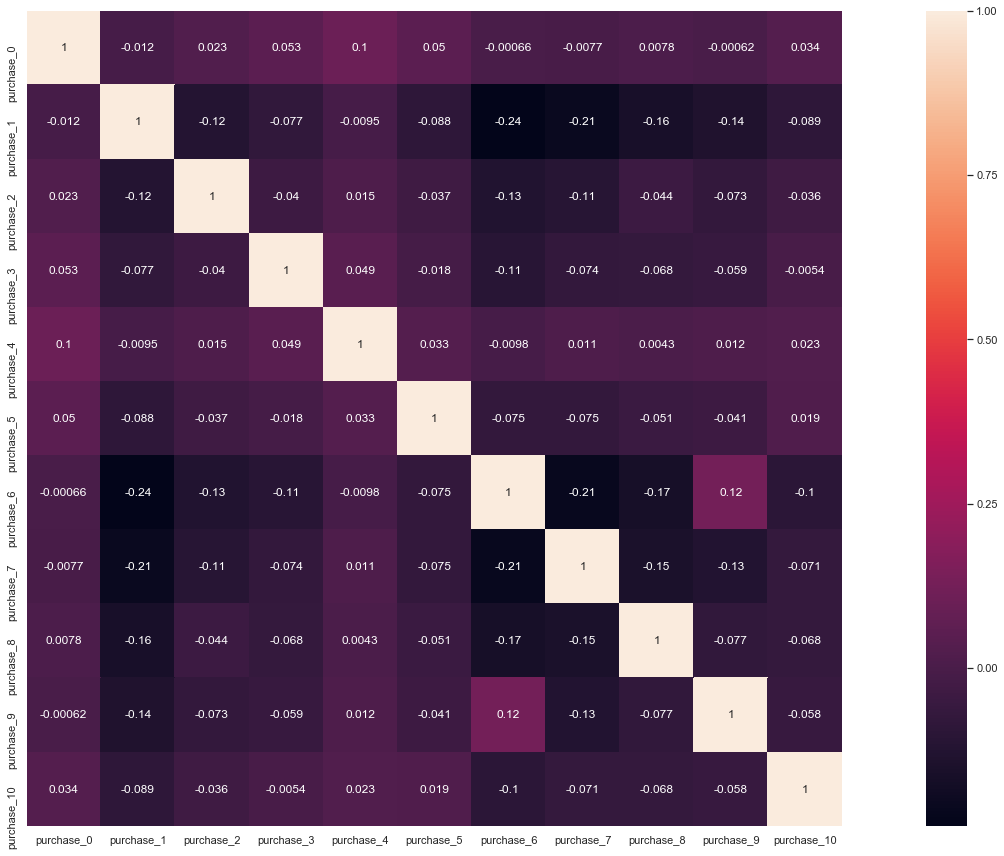

In [1616]:
sns.set(rc={'figure.figsize':(30,15)})
sns.heatmap(corr, square=True,annot=True)

In [1617]:
data_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 11 columns):
purchase_0     2452 non-null float64
purchase_1     2452 non-null float64
purchase_2     2452 non-null float64
purchase_3     2452 non-null float64
purchase_4     2452 non-null float64
purchase_5     2452 non-null float64
purchase_6     2452 non-null float64
purchase_7     2452 non-null float64
purchase_8     2452 non-null float64
purchase_9     2452 non-null float64
purchase_10    2452 non-null float64
dtypes: float64(11)
memory usage: 210.8 KB


In [1618]:
sc = StandardScaler()

In [1619]:
X_sc = sc.fit_transform(data_cl)

In [1620]:
linked = linkage(X_sc, method = 'ward')

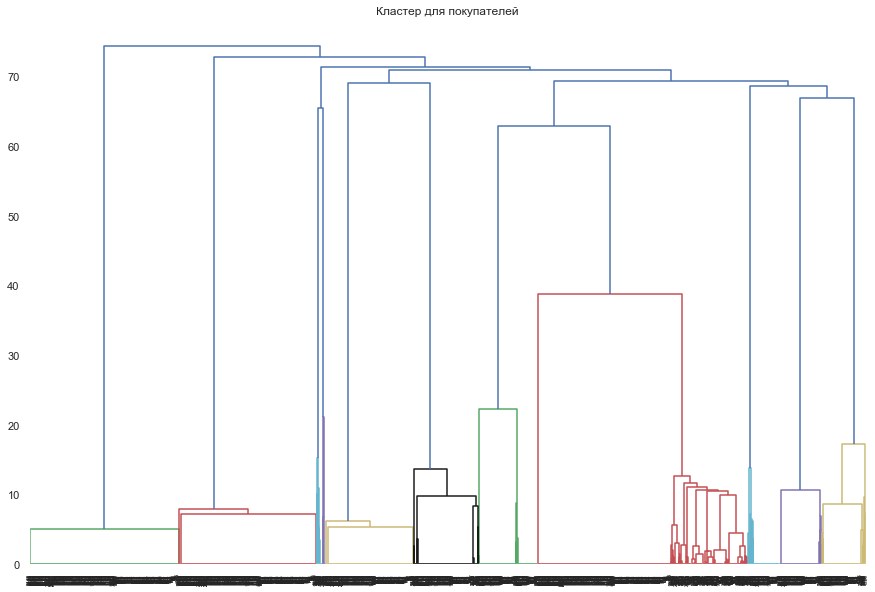

In [1621]:
plt.figure(figsize=(15, 10))  
dendrogram(linked)
plt.title('Кластер для покупателей')
plt.show()

In [1622]:
km = KMeans(n_clusters = 11)

In [1623]:
labels = km.fit_predict(X_sc)

In [1624]:
data_cl['cluster_km'] = labels

D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1625]:
claster_group = data_cl.groupby(['cluster_km']).mean()

In [1626]:
claster_group

,purchase_0,purchase_1,purchase_2,purchase_3,purchase_4,purchase_5,purchase_6,purchase_7,purchase_8,purchase_9,purchase_10
cluster_km,,,,,,,,,,,
0,0.000000,0.941629,0.000000,0.001025,0.000000,0.000000,0.004098,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.021898,0.014599,0.000000,0.000000,0.000000,0.014599,0.051095,0.014599,0.000000,0.947689
2,0.000000,0.000037,0.000719,0.000759,0.000096,0.000369,0.914420,0.000000,0.000221,0.005591,0.000522
3,0.000000,0.010083,0.000903,0.000752,0.000000,0.000752,0.011287,0.953499,0.000752,0.000000,0.000000
4,0.000000,0.061508,0.024306,0.942678,0.000000,0.000000,0.013889,0.041667,0.020833,0.006944,0.034722
5,0.111111,0.111111,0.111111,0.212121,1.000000,0.111111,0.111111,0.222222,0.111111,0.111111,0.111111
6,0.000000,0.010563,0.001761,0.000000,0.000000,0.000000,0.000000,0.008803,0.949237,0.001174,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.344556,0.005208,0.023438,0.947529,0.000000
8,0.000000,0.005319,0.963652,0.000000,0.000000,0.000000,0.005319,0.005319,0.047872,0.000000,0.000000


purchase_0


D:\Users\ansee\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\Users\ansee\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


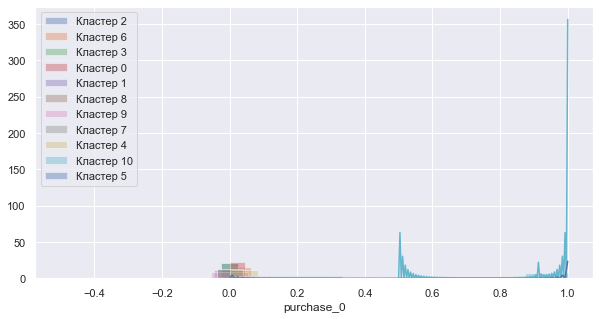

purchase_1


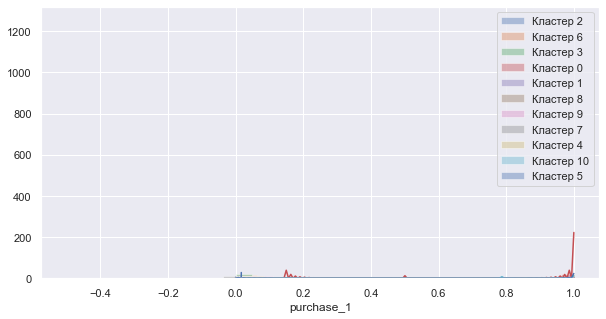

purchase_2


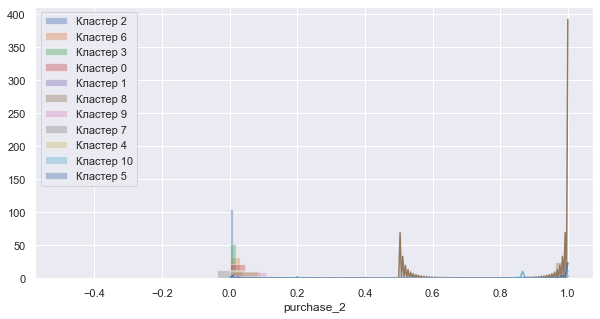

purchase_3


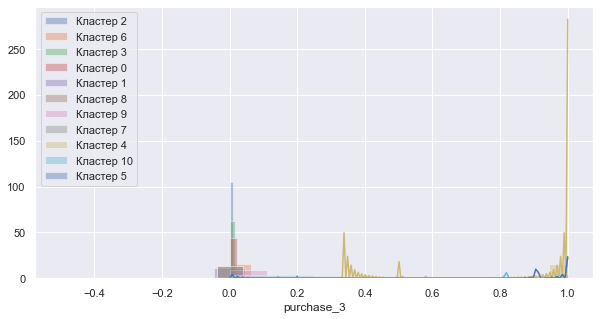

purchase_4


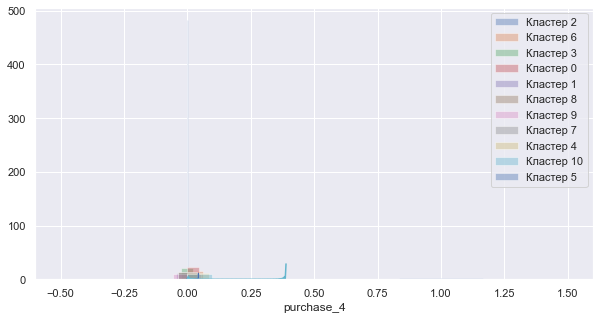

purchase_5


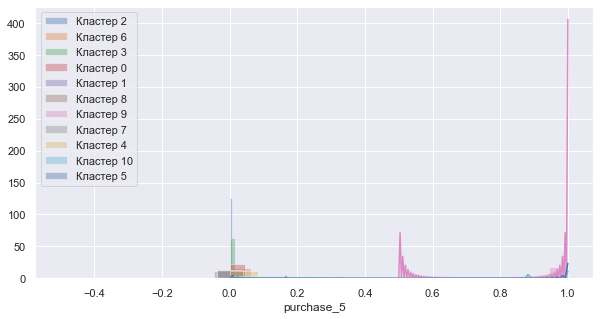

purchase_6


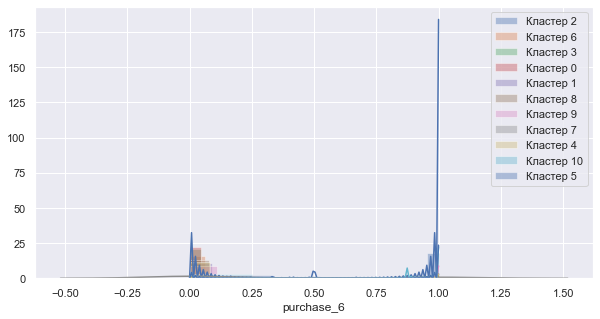

purchase_7


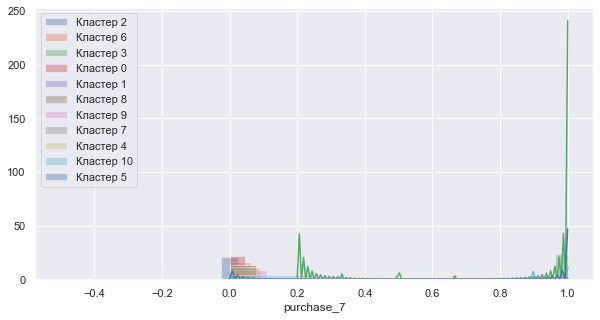

purchase_8


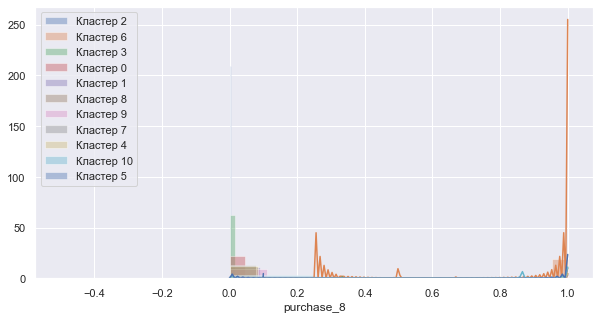

purchase_9


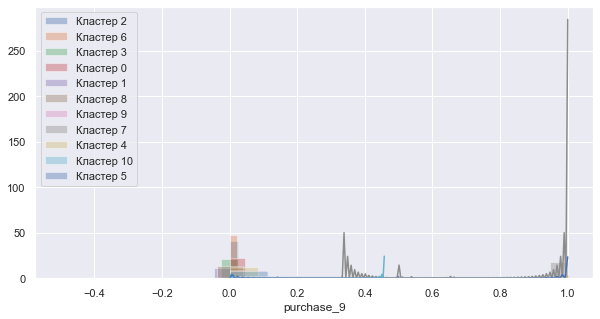

purchase_10


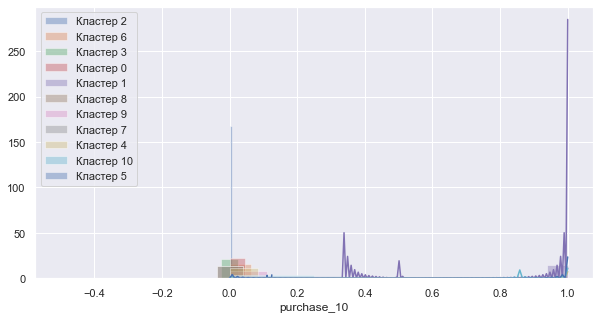

cluster_km


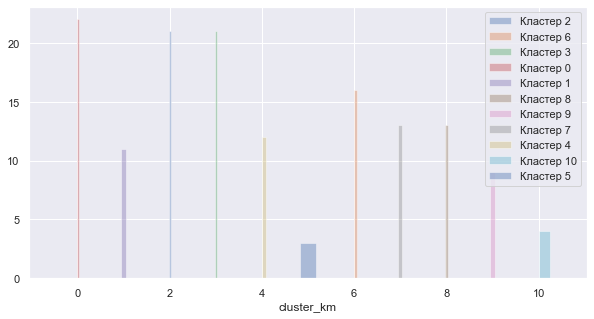

In [1627]:
for f in data_cl.columns:
    print(f)
    plt.figure(figsize = (10, 5))
    for i in data_cl['cluster_km'].unique():
        sns.distplot(data_cl.query('cluster_km == @i')[f], label='Кластер {}'.format(i))
    legend = plt.legend()
    
    
    plt.show()


Вывод
----

Было выделено 11 кластеров: 
   1. Первый кластер делает основные покупки из первой группы 6: вереки, вешалки, лестницы, мебель, постельные принадлежности, сумки, товары для уборки и прочие товары. 
   2. Второй клстер делвет основные покупки из группы товаров для туалета и ванны, товары для тела. Также для данной группы товаров можно делать совместные предложения со следующими товарами: товары для кухни, столовые приборы и недорогое кухонное оборудование, в меньшей степени вереки, вешалки, лестницы, мебель, постельные принадлежности, сумки, товары для уборки и прочие товары. 
   3. Третий кластер приобретает только комнатные растения
   4. Четвертый кластер: товары для кухни. Совместно к данной группе товаров можно предложить товары комнатные растения и всякие мелочи для дома.
   5. Покупатели различных емкостей. Совместно они могут покупать такие товары как всякие бытовые мелочи, кухонные мелочи, товары для туалета и ванны.
   6. Шестой кластер. Измирительные приборы и инструменты. покупатели из этой группы много покупают товаров из группы емкости и товары для кухни. Товары из остальных групп также покупают совместно.
   7. Седьмой кластер. В основном покупают семена и рассаду и всякие мелочи для данной группы товаров.
   8. Восьмой кластер. В основном покупает рассаду и семена и достаточно много покупает товаров из группы комнатные растения.
   9. Девятый кластер. В основном покупают товары для глажки и иногда могут совместно с ними приобрести всякие бытовые мелочи
   10. Десятый кластер. В основном покупают ттовары из группы ковры. Совместно с ними покупают такие тованые группы как бытовые мелочи, емкости и товары для глажки.
   11. Товары из бытовой химии хорошо торгуются вместе с бытовыми мелочами, товарами для глажки и емкостями, коврами и комнатными растениями, кухонными товарами и товарарми для туалета и ванны.

In [1662]:
data_a_summa = data.pivot_table(['summa'], index='customer_id', columns='class_produkt_n', margins=True).reset_index()

In [1690]:
data_a_summa.columns = ['customer_id', 'summa_0', 'summa_1', 'summa_2', 'summa_3',
                 'summa_4', 'summa_5', 'summa_6', 'summa_7', 'summa_8', 'summa_9', 'summa_10', 'summa_all']

In [1691]:
data_a_summa = data_a_summa.fillna(0)

In [1692]:
data_cl = data_a_summa[['summa_0', 'summa_1', 'summa_2', 'summa_3',
                 'summa_4', 'summa_5', 'summa_6', 'summa_7', 'summa_8', 'summa_9', 'summa_10']]

In [1693]:
corr=data_cl.corr()

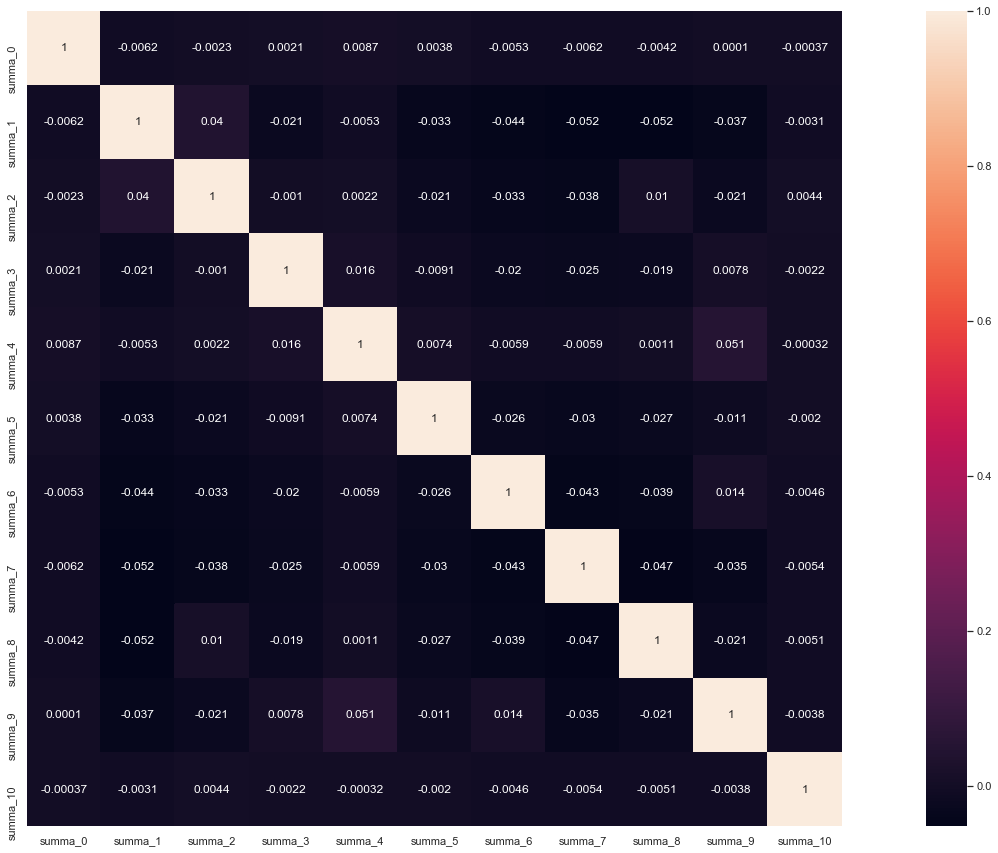

In [1694]:
sns.set(rc={'figure.figsize':(30,15)})
sns.heatmap(corr, square=True,annot=True)

In [1695]:
sc = StandardScaler()

In [1696]:
X_sc = sc.fit_transform(data_cl)

In [1697]:
linked = linkage(X_sc, method = 'ward')

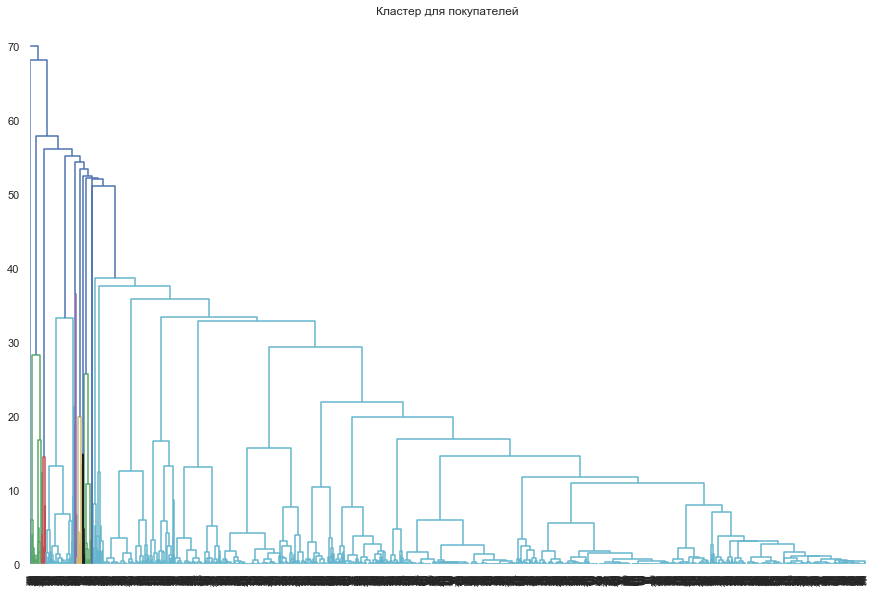

In [1698]:
plt.figure(figsize=(15, 10))  
dendrogram(linked)
plt.title('Кластер для покупателей')
plt.show()

In [1699]:
km = KMeans(n_clusters = 7)

In [1700]:
labels = km.fit_predict(X_sc)

In [1701]:
data_cl['cluster_km'] = labels

D:\Users\ansee\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1706]:
claster_group_1 = data_cl.groupby(['cluster_km']).mean()

In [1708]:
claster_group_1

,summa_0,summa_1,summa_2,summa_3,summa_4,summa_5,summa_6,summa_7,summa_8,summa_9,summa_10
cluster_km,,,,,,,,,,,
0,1.796662,449.842223,117.792577,58.974320,1.030384,53.002051,67.917614,113.697895,132.639236,10.892100,63.269464
1,5399.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,675000.000000
3,0.000000,0.000000,0.000000,0.000000,1849.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10030.000000,0.000000,0.000000,0.000000,0.000000
5,4.100000,104.075000,55.384211,108.631818,34.650000,37.970000,92.537821,25.903571,63.928000,984.858333,52.325000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6491.083333,0.000000,0.000000,0.000000


Вывод
----

Было выделено 7 кластеров: 
   1. Первый кластер - это клиенты, которые тартят по чуть-чуть но во всех товарных группах. Ключевая группа бытовые мелочи. 
   2. Второй кластер - покупатели бытовой химиии. Покупают ее на большую сумму.
   3. Третий кластер - покупатели товаров для туалета и ванны. Покупают на большую сумму.
   4. Четвертый кластер - измирительные приборы и инструменты.
   5. Пятый кластер - покупатели комнатных растений.
   5. Шестой кластер - это клиенты, которые тратят совсем мало денег. Ключевые траты приходятся на рассаду. 
   6. Седьмой кластер - это траты н кухонные товары и принадлежности. 


Список литературы
-----


 1. [What is One Hot Encoding? Why And When do you have to use it?](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) В статье описаны причины необходимости использования "One Hot Encoding" на примере категориальных примеров. И хорошо проиллюстрировала, что необходимо делать мне для того, что бы исправить мою ошибку.
 2. [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) Описана документация по фукции preprocessing.OneHotEncoder(). Данная фукнция позволяет закодировать категориальные функции в виде однознчного числового массива. 
 3. [ABC и XYZ анализ продаж: что и как считать](https://yagla.ru/blog/analitika/abc-i-xyz-analiz-prodazh/). В статье описан механизм рассчета АВС и XYZ - анализы и особенности интерпретации данного анализа.
 4. [АВС анализ в маркетинге: как правильно использовать на практике](http://powerbranding.ru/biznes-analiz/abc-method/) шаблон анализа

Резюме о проделанной работе
------

  1. Разделены пользователи на группы, которые совершили одну сделку, и группы, которые совершили 2 и более сделок.
  2. Проведен АВС-анализ пользователей, которые совершили 1 сделку
  3. Проведен ABC и XYZ-анализ пользователей, которые совершили 2 и более сделки
  4. Выделены сегменты и подсигменты
  5. Проведена лемматизация товарных групп и выделено 28 категорий товаров, объединенные в 11 классов.
  6. Выделены сегменты на основе успешности продаж по клиентам и группам товаров
  7. Выделены сегменты на основе объема продаж.
  8. Немного поработал с литтературой.

Выводы 1
-----
   1. Для клентов совершивших 1 сделку:
        1. Клинеты из группы А занимают 47,86% от всех клиентов, совершивших одну сделку, и приносят 80% выручки от клиентов совершивших одну сделку. Минимальный закупки составляют 375 у.е. Максимальный объем закупок 1319 у.е.
        2. Клиенты из группы В занимают 29,2% и приносят 15% выручки. Минимальный закупки составляют 142 у.е. Максимальный объем закупок 375 у.е.
        3. Группа С занимают 22,94% и приносят 5% выручки. Минимальный закупки составляют 14 у.е. Максимальный объем закупок 142 у.е.
   2. Для клиентов совершивших 2 и более сделки:
         1. В ходе анализа у нас получилось 9 групп, которые можно объединить в 3 группы:
            - Сегмент 1: AX, AY, BX. MIN объем закупки (суммарный) - 414 у.е., MAX объем закупки (суммарный) - 2548 у.е.
            - Сегмент 2: AZ, BY, CX. MIN объем закупки (суммарный) - 276 у.е., MAX объем закупки (суммарный) - 4691 у.е., клиенты совершают 2 сделки.
            - Сегмент 3: BZ, CY, CZ. MIN объем закупки (суммарный) - 81 у.е., MAX объем закупки (суммарный) - 429 у.е., клиенты совершают 2 сделки.
         2. Все эти группы покупателей важны для нас и требуют чуткого взаимодействия с ними, т.к. осуществляют большей объем закупок.
         3. Самой важным сегментом для нас явлется сегмент 1, с данной группой покупателей необходимо выстраивать взаимоотношения. 


Выводы 2
-----

На основе упешности покупок клиентами было выделено 11 кластеров: 
   1. Первый кластер делает основные покупки из первой группы 6: вереки, вешалки, лестницы, мебель, постельные принадлежности, сумки, товары для уборки и прочие товары. 
   2. Второй клстер делвет основные покупки из группы товаров для туалета и ванны, товары для тела. Также для данной группы товаров можно делать совместные предложения со следующими товарами: товары для кухни, столовые приборы и недорогое кухонное оборудование, в меньшей степени вереки, вешалки, лестницы, мебель, постельные принадлежности, сумки, товары для уборки и прочие товары. 
   3. Третий кластер приобретает только комнатные растения
   4. Четвертый кластер: товары для кухни. Совместно к данной группе товаров можно предложить товары комнатные растения и всякие мелочи для дома.
   5. Покупатели различных емкостей. Совместно они могут покупать такие товары как всякие бытовые мелочи, кухонные мелочи, товары для туалета и ванны.
   6. Шестой кластер. Измирительные приборы и инструменты. покупатели из этой группы много покупают товаров из группы емкости и товары для кухни. Товары из остальных групп также покупают совместно.
   7. Седьмой кластер. В основном покупают семена и рассаду и всякие мелочи для данной группы товаров.
   8. Восьмой кластер. В основном покупает рассаду и семена и достаточно много покупает товаров из группы комнатные растения.
   9. Девятый кластер. В основном покупают товары для глажки и иногда могут совместно с ними приобрести всякие бытовые мелочи
   10. Десятый кластер. В основном покупают ттовары из группы ковры. Совместно с ними покупают такие тованые группы как бытовые мелочи, емкости и товары для глажки.
   11. Товары из бытовой химии хорошо торгуются вместе с бытовыми мелочами, товарами для глажки и емкостями, коврами и комнатными растениями, кухонными товарами и товарарми для туалета и ванны.

Вывод 3
----

На основе объема продаж было выделено 7 кластеров: 
   1. Первый кластер - это клиенты, которые тартят по чуть-чуть но во всех товарных группах. Ключевая группа бытовые мелочи. 
   2. Второй кластер - покупатели бытовой химиии. Покупают ее на большую сумму.
   3. Третий кластер - покупатели товаров для туалета и ванны. Покупают на большую сумму.
   4. Четвертый кластер - измирительные приборы и инструменты.
   5. Пятый кластер - покупатели комнатных растений.
   5. Шестой кластер - это клиенты, которые тратят совсем мало денег. Ключевые траты приходятся на рассаду. 
   6. Седьмой кластер - это траты н кухонные товары и принадлежности. 